## Machine Learning for the Geological Sciences
###  Application Workflow on Production Prediction using Random Forest Model Given 1 of the 7 Sampling Methods
##### By: Jackson R. Tomski – Geophysicist/Machine Learning Specialist

First derive optimal features by performing series of statistical measures during feature selection

Synthetic Unconventional Reservoir Dataset comes from Michael J. Pyrcz at the link below:
* Tabular data - unconv_MV.csv at https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV.csv
* This dataset has 1000 wells, and has the following features:
    * WellIndex, Por, LogPerm, AI, Brittle, TOC, VR, and Production, where I have added latitude and longitude columns

#### Workflow Overview:
I make use of an unconventional reservoir dataset to identify production patterns in the field to establish a relationship between possible petrophysical parameters and production by generating an enhanced Artificial Intelligence (AI) workflow. To do this, I first engineer the features before employing a series of feature selection methods to determine the optimal features to utilize when predicting production. Various training and testing datasets are generated by employing random sampling, K-means Clustering, and Gaussian Mixture Models in order to sample from the map area. I do this in order to reduce the sampling bias and ensure that the machine learning models are being trained and tested on data coming from similar geological regions with similar production rate values. This workflow will then employ a random forest model on its effectiveness to predict production given a determined set of predictive features for a given training and testing dataset scenario, where I tune the hyperparameter each time for a given sampling method. The result of this workflow should demonstrate that with the integration of these techniques, a better understanding of the parameters useful for optimizing oil production is possible.

Load in libraries and the desired dataset

In [1]:
###################################################################################################################
import numpy as np                                              # ndarrys for gridded data
import pandas as pd                                             # DataFrames for tabular data
import os                                                       # Set working directory, run executables
import copy                                                     # For deep copies
import time                                                     # Track computational time
import warnings                                                 # Allows the code to ignore uneccessary warnings
import seaborn as sns                                           # For matrix scatter plots
import matplotlib.pyplot as plt                                 # For plotting
import math                                                     # Trigonometry etc.
import random                                                   # For randon numbers
import shutil                                                   # To help direct folder to output figures
from scipy import linalg                                        # For linear regression
from scipy import stats                                         # Summary statistics and statistical methods
from scipy.spatial import Voronoi, voronoi_plot_2d              # For plotting Voronoi diagram across K-means clusters
from sklearn import mixture                                     # In order to perform GMMs Clustering
from sklearn import preprocessing                               # Allows for feature engineering
from sklearn.preprocessing import MinMaxScaler                  # Min/max normalization
from sklearn.preprocessing import StandardScaler                # Standardization
from sklearn.ensemble import RandomForestRegressor              # A random forest regressor
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression    # Measurement of the dependency between two variables
from sklearn.cluster import KMeans                              # K-mens clustering – for data clustering
from sklearn.model_selection import train_test_split            # Dataset spplit to get training and testing datasets
###################################################################################################################
warnings.filterwarnings('ignore')
sns.set(font_scale=0.8)
###################################################################################################################
os.chdir("/Users/jacksontomski/Desktop/GitHub_Uploads/")
df = pd.read_excel("Unconventional_Synthetic_Dataset.xlsx")
###################################################################################################################
df.describe().T
###################################################################################################################

,count,mean,std,min,25%,50%,75%,max
WellIndex,1000.0,500.500000,288.819436,1.000000,250.750000,500.500000,750.250000,1000.000000
Por,1000.0,14.950460,3.029634,5.400000,12.857500,14.985000,17.080000,24.650000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.130000,1.390000,1.680000,2.580000
AI,1000.0,2.982610,0.577629,0.960000,2.577500,3.010000,3.360000,4.700000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.722500,49.680000,59.170000,93.470000
TOC,1000.0,1.003810,0.504978,-0.260000,0.640000,0.995000,1.360000,2.710000
VR,1000.0,1.991170,0.308194,0.900000,1.810000,2.000000,2.172500,2.900000
Latitude,1000.0,17.372735,0.117241,16.976527,17.313574,17.376347,17.433568,17.755489
Longitude,1000.0,32.021531,0.125404,31.781801,31.912113,32.018054,32.123248,32.382423
Production,1000.0,2247.295809,1464.256312,2.713535,1191.369560,1976.487820,3023.594214,12568.644130


#### Set the working directory

In [2]:
###################################################################################################################
name = 'Production_Results'
problemfolder_db = 'z_Feature_Selection'                # Save main results
path_db = (problemfolder_db + '_' + name)               # Name of the folder within the mcmc results folder
print(path_db)
###################################################################################################################
if not os.path.exists(path_db):                         # If the directory does not exist
    os.makedirs(path_db)                                # Make the directory
else:                                                   # Else, the directory exists
    shutil.rmtree(path_db)
    os.makedirs(path_db)
###################################################################################################################

z_Feature_Selection_Production_Results


Drop the WellIndex column

In [3]:
###################################################################################################################
df = df.drop(columns=['WellIndex'])
df = df.reset_index(drop=True)
print(df.shape)
df.head()
###################################################################################################################

(1000, 9)


,Por,LogPerm,AI,Brittle,TOC,VR,Latitude,Longitude,Production
0,15.91,1.67,3.06,14.05,1.36,1.85,17.755442,32.217456,177.381958
1,15.34,1.65,2.60,31.88,1.37,1.79,17.375124,31.843049,1479.767778
2,20.45,2.02,3.13,63.67,1.79,2.53,17.324000,31.983195,4421.221583
3,11.95,1.14,3.90,58.81,0.40,2.03,17.261452,31.970910,1488.317629
4,19.53,1.83,2.57,43.75,1.40,2.11,17.250556,31.940999,5261.094919


Now plot the histogram distributions of the original raw data

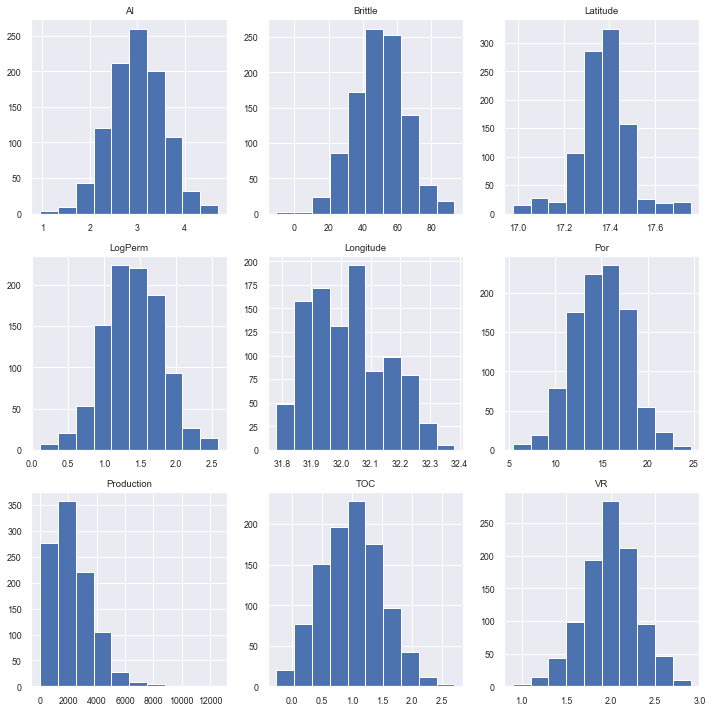

In [4]:
###################################################################################################################
df.hist(figsize=(10, 10))
plt.tight_layout()
plt.savefig(path_db + '/Original_Histograms.png', bbox_inches='tight')
plt.show()
###################################################################################################################

#### Perform feature engineering
Then plot the new histogram distributions of the engineered data

Feature engineering is performed to mitigate the effect of potential outliers, ensure that the machine learning models are performing optimally, and to achieve optimal machine learning model performance.

cum_oil_365 min:  0.0050000000000000044
cum_oil_365 max:  0.995


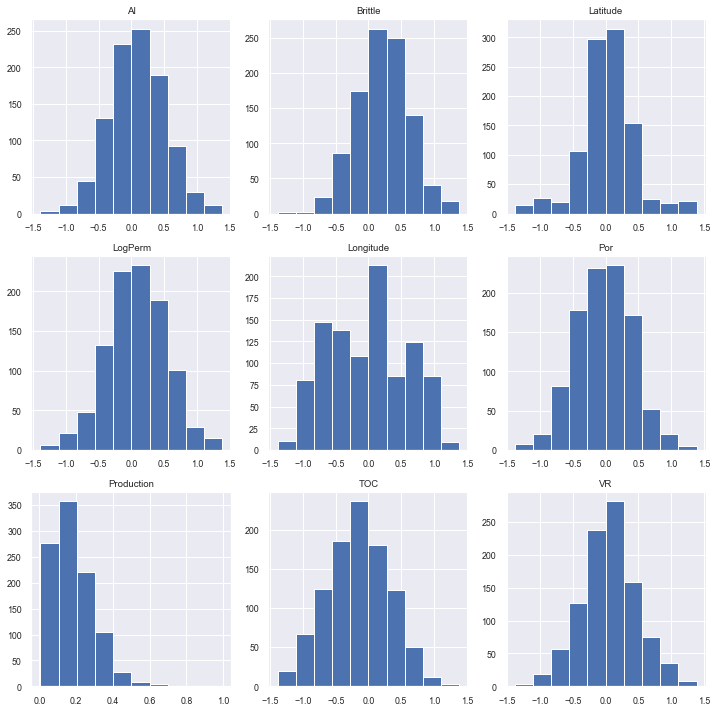

In [5]:
###################################################################################################################
def feature_engineering(df_data1, min_pred_norm, max_pred_norm, min_target_norm, max_target_norm):
    """
    :param df_data1: The original/raw unconventional reservoir dataset containing production data
    :param min_pred_norm: The min predictive feature normalization
    :param max_pred_norm: The max predictive feature normalization
    :param min_target_norm: The min target feature normalization
    :param max_target_norm: The max target feature normalization
    :return: New dataset with features engineered and then min/max normalized
    """
    columns = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production']
    df_org = pd.DataFrame(df_data1, index=df_data1.index, columns=df_data1.columns) # Original/raw dataset
    y_target = df_org['Production']                                                 # Target Feature
    df_data2_norm = df_org.iloc[:, :-1]                                             # Possible predictive features
    
    ''' Standardize the data (i.e., generate Z-Scores) '''
    # Predictive Features
    scaler = preprocessing.StandardScaler().fit(df_data2_norm)
    df_data2_norm1 = scaler.fit_transform(df_data2_norm)
    df_data2_norm = pd.DataFrame(df_data2_norm1, index=df_data2_norm.index, columns=df_data2_norm.columns)
    # Target Feature
    y_target = np.array([y_target]).transpose()
    scaler = preprocessing.StandardScaler().fit(y_target)
    y_target1 = scaler.fit_transform(y_target)
    y_target = pd.DataFrame(y_target1, columns=['Production'])
    
    ''' Scale the data between the 25th and 75h quartiles '''
    # Predictive Features
    scaler = preprocessing.RobustScaler().fit(df_data2_norm)
    df_data2_norm1 = scaler.transform(df_data2_norm)
    df_data2_norm = pd.DataFrame(df_data2_norm1, index=df_data2_norm.index, columns=df_data2_norm.columns)
    # Target Feature
    scaler = preprocessing.RobustScaler().fit(y_target)
    y_target1 = scaler.fit_transform(y_target)
    y_target = pd.DataFrame(y_target1, columns=['Production'])
    
    ''' Transform the predictive features to Gaussian-like '''
    # Predictive Features
    scaler = preprocessing.PowerTransformer().fit(df_data2_norm)
    df_data2_norm1 = scaler.transform(df_data2_norm)
    df_data2_norm = pd.DataFrame(df_data2_norm1, index=df_data2_norm.index, columns=df_data2_norm.columns)
    
    ''' Min/max normalize the data '''
    # Predictive Features
    scaler = preprocessing.MinMaxScaler(feature_range=(min_pred_norm, max_pred_norm)).fit(df_data2_norm)
    df_data2_norm1 = scaler.transform(df_data2_norm)
    df_data2_norm = pd.DataFrame(df_data2_norm1, index=df_data2_norm.index, columns=df_data2_norm.columns)
    # Target Feature: Keep target feature between 0 and 1 since using a sigmoid activation function in the BNN
    scaler = preprocessing.MinMaxScaler(feature_range=(min_target_norm, max_target_norm)).fit(y_target)
    y_target_norm1 = scaler.transform(y_target)
    y_target_norm = pd.DataFrame(y_target_norm1, columns=['Production'])
    y_target_norm = y_target_norm.replace(0, 0.0001)  # Cause can't divide by zero when calculting the MAPE
    
    ''' Finalize the new engineered dataset '''
    df1 = pd.DataFrame(df_data2_norm, columns=['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude'])
    df2 = pd.DataFrame(y_target_norm, columns=['Production'])
    df_data2_norm = pd.concat([df1, df2], axis=1)
    
    return df_data2_norm
###################################################################################################################
df = feature_engineering(df, -1.3875, 1.3875, 0.005, 0.995)
print('cum_oil_365 min: ', df['Production'].min())
print('cum_oil_365 max: ', df['Production'].max())
###################################################################################################################
df.hist(figsize=(10, 10))
plt.tight_layout()
plt.savefig(path_db + '/Engineered_Histograms.png', bbox_inches='tight')
plt.show()
###################################################################################################################

#### Performing feature section to find the optimal features that will give the best model results (i.e., highest explained variance and lowest RMSE)
##### Plotting the correlation, rank_correlation, and partial_correlation along with the feature importance and mutual information

* __Correlation__: Looking to the correlation that each feature has on predicting production

* __Rank Correlation__: Checking to see if there are any outliers that are skewing the correlation between predictive features and target feature

* __Feature Importance__: Looking into the degree of feature importance when predicting production

* __Mutual Information__: Checking to see the how one feature is dependent on another, and the other way around. In other words (for example), given porosity, we have production, and given production, we have porosity. To elaborate, we need space to store the hydrocarbons, otherwise we are just drilling into solid bedrock

#### Below is a function for calculating the various correlations

In [6]:
###################################################################################################################
correlation = df.corr().iloc[-1, :-1]
rank_correlation, rank_correlation_pval = stats.spearmanr(df) 
rank_correlation = rank_correlation[:, -1][:-1]
rank_correlation_pval = rank_correlation_pval[:, -1][:-1]
rank_correlation_scatter, rank_correlation_pval = stats.spearmanr(df)
###################################################################################################################

Correlation matrix scatter plot down below makes a matrix correlation figure that has a degree of correlation between feature x and feature y, where we want features that have a high correlation to the target feature (i.e., Production), but have a low correlation between each other (Por and Latitude)

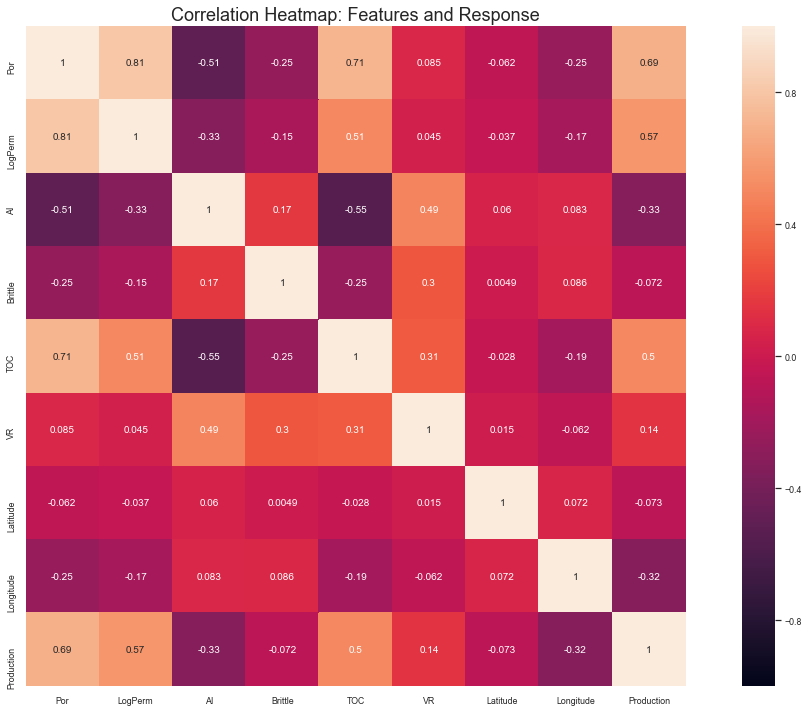

In [7]:
###################################################################################################################
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True, linewidth=0, vmin=-1, square=True)
plt.title("Correlation Heatmap: Features and Response", size=18)
###################################################################################################################
plt.tight_layout()
plt.savefig(path_db + '/Correlation_Heatmap.png', bbox_inches='tight')
plt.show()
###################################################################################################################

Rank correlation matrix scatter plot down below makes a matrix correlation figure that has a degree of correlation between feature x and feature y while considering the impact of outliers

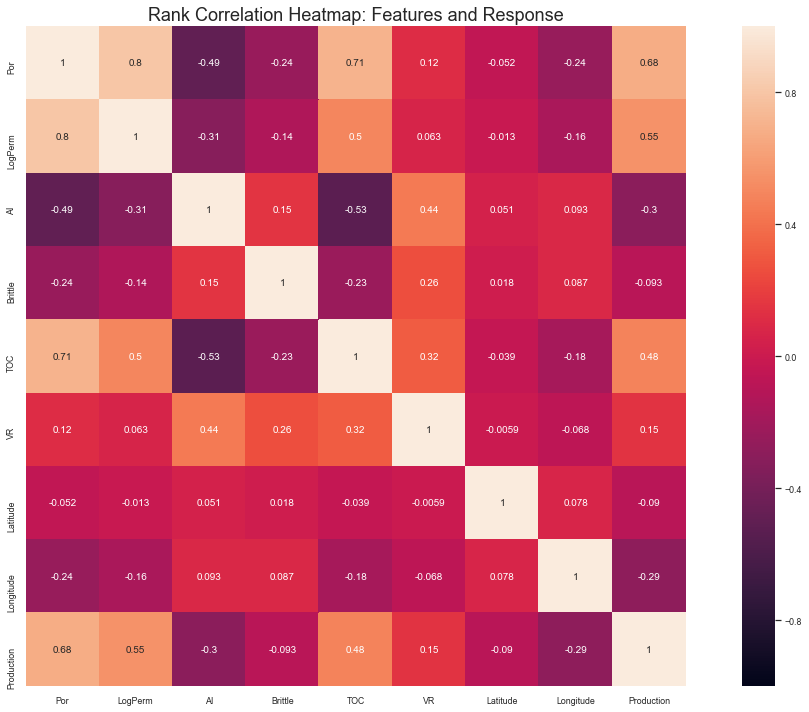

In [8]:
###################################################################################################################
plt.figure(figsize=(16, 10))
xticks = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production']
yticks = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production']
sns.heatmap(rank_correlation_scatter, annot=True, linewidth=0, vmin=-1, square=True, xticklabels=xticks, yticklabels=yticks)
plt.title("Rank Correlation Heatmap: Features and Response", size=18)
###################################################################################################################
plt.tight_layout()
plt.savefig(path_db + '/Rank_Correlation_Heatmap.png', bbox_inches='tight')
plt.show()
###################################################################################################################

The function here plots the feature importance that each feature has on production, and the mutal importance they share against production

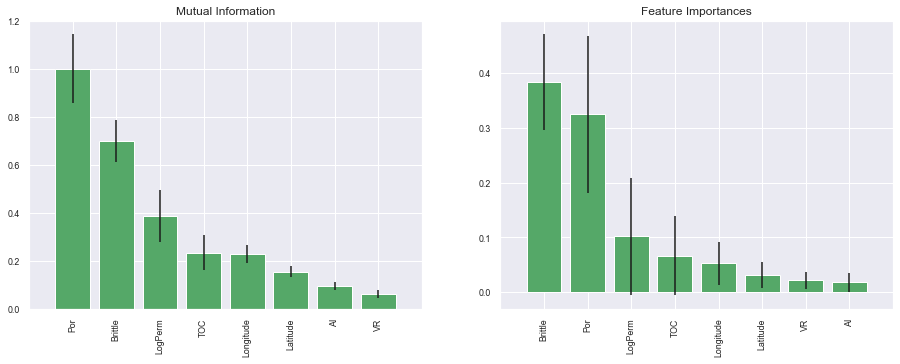

In [9]:
###################################################################################################################
def feature_infromation():
    """
    :return: None
    """
    # Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
    x = df.iloc[:, [0,1,2,3,4,5,6,7]]  # Separate DataFrames for predictor and response features
    y = df.iloc[:, [8]]
    lab_enc = preprocessing.LabelEncoder()                      # This removes an encoding error
    y_encoded = lab_enc.fit_transform(y)                        # This removes an encoding error 
    ###############################################################################################################
    mi = mutual_info_regression(x,np.ravel(y_encoded))          # Calculate mutual information
    mi /= np.max(mi)                                            # Calculate relative mutual information
    indices1 = np.argsort(mi)[::-1]                             # Find indicies for descending order
    ###############################################################################################################
    random_states = 5195
    n_est = 100
    md = 25
    random_forest = RandomForestRegressor(oob_score=True, max_depth=md, random_state=random_states, n_estimators=n_est, max_features=3)
    ###############################################################################################################
    random_forest = random_forest.fit(x,np.ravel(y_encoded))    # Fit the random forest
    importances = random_forest.feature_importances_            # Extract the expected feature importances
    std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)   # Calculate stdev over trees
    indices2 = np.argsort(importances)[::-1]                    # Find indicies for descending order
    ###############################################################################################################
    plt.subplot(1, 2, 1)                                        # Plot the relative mutual information 
    plt.title("Mutual Information", size=12)
    plt.bar(range(x.shape[1]), mi[indices1], color="g", yerr=std[indices1], align="center")
    plt.xticks(range(x.shape[1]), x.columns[indices1], rotation=90)
    plt.xlim([-1, x.shape[1]])
    ###############################################################################################################
    plt.subplot(1, 2, 2)                                        # Plot the feature importance 
    plt.title("Feature Importances", size=12)
    plt.bar(range(x.shape[1]), importances[indices2], color="g", yerr=std[indices2], align="center")
    plt.xticks(range(x.shape[1]), x.columns[indices2],rotation=90)
    plt.xlim([-1, x.shape[1]])
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1., wspace=0.2, hspace=0.2)
    plt.savefig(path_db + '/Mutual_Info_and_Feature_Import.png', bbox_inches='tight')
    plt.show()
###################################################################################################################
feature_infromation()
###################################################################################################################

It appears that the four optimal features are __Brittle, Por, Latitude, and Longitude__. This is because we achieve a high correlation and rank correlation to Production with Por and Longitude. Indeed, LogPerm and TOC are idea features too, but they share a high correlation to Por. When going down to looking at the feature importance and mutual information, we find that Brittle is rank high in both, with Longitude and Latitude following right after LogPerm and TOC. We can keep adding features like LogPerm or TOC, but that would increase the dimensionality of the problem, and increase the chance of redundant features (where as mentioned, they are highly correlated to Por); thereby, hindering the machine learning model performance and decreasing the interpretability of the model. Therefore, we can move forward with Brittle, Por, Latitude, and Longitude as the optimal features for predicting Production.

And lastly, before getting in picking a sampling method to derive a training and testing dataset. let's generating a scatter plot of where the resulting production wells lie (with their min/max normalized corresponding production value clipped between their 5th and 95th percentile) given latitude and longitude and the x and y-axis. This way we can visualize what we are sampling from when generating those training and testing datasets.

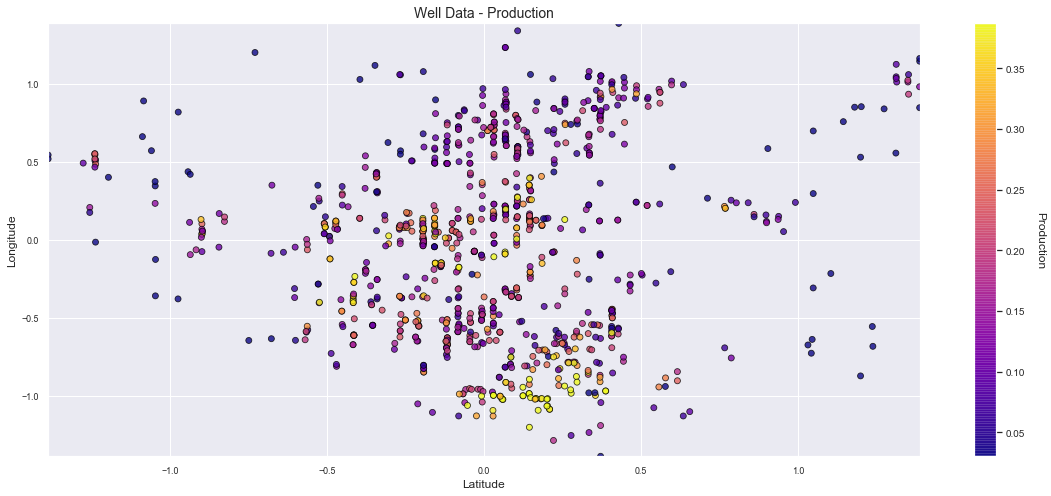

In [10]:
###################################################################################################################
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1)
###################################################################################################################
lat = df['Latitude']; long = df['Longitude']; cum_oil_365 = df['Production']
plt.ylim([long.min(), long.max()])
plt.xlim([lat.min(), lat.max()])
cum_oil_365_p05 = np.percentile(cum_oil_365.values, 5, axis=0)      # apx = 32194,  where min = 3821
cum_oil_365_p95 = np.percentile(cum_oil_365.values, 95, axis=0)     # apx = 179080, where max = 501641
###################################################################################################################
cax = ax.scatter(lat, long, c=cum_oil_365, cmap=plt.cm.plasma, vmin=cum_oil_365_p05, vmax=cum_oil_365_p95, alpha=0.8, linewidths=0.8, edgecolors="black")
cbar = fig.colorbar(cax)
cbar.set_label('Production', rotation=270, size=12, labelpad=20)
cbar.ax.tick_params(labelsize=10)
plt.ylabel('Longitude', size=12)
plt.xlabel('Latitude', size=12)
plt.title('Well Data - Production', size=14)
###################################################################################################################
plt.tight_layout()
fig.savefig(path_db + '/Well_Data_ScatterPlot.png', bbox_inches='tight')
plt.show()
###################################################################################################################

So that will be the map we will be sampling from in order to create our training and testing datsets

With the optimal features found, let's get into predicting production using those features. First, let's pick a sampling method

There are seven to choose from, these are:
1. Random Sampling
2. K-means Clustering using a random state of 9307 to generate the initial clusters/prototypes
3. K-means Clustering using a random state of 0 to generate the initial clusters/prototypes
4. Gaussian Mixture Model (GMM) that utilizing a full covariance type
5. GMM that utilizing a spherical covariance type
6. GMM that utilizing a diag covariance type
7. GMM that utilizing a tied (i.e., shared full) covariance type

#### Select sampling method

In [11]:
###################################################################################################################
sampling_method01 = 'Random'
sampling_method02 = 'K-means random state 9307'
sampling_method03 = 'K-means random state 0'
sampling_method04 = 'full'                      # Gaussian Mixture Model (GMM) based
sampling_method05 = 'spherical'                 # GMM based
sampling_method06 = 'diag'                      # GMM based
sampling_method07 = 'tied'                      # GMM based
###################################################################################################################
sampling_method = sampling_method07
print('Chosen Sampling Method -->', sampling_method)
###################################################################################################################

Chosen Sampling Method --> tied


#### Set the new working dictionary

In [12]:
###################################################################################################################
name = 'Prediction_Results_Given'
problemfolder_db = 'z_Production'                       # Save main results
path = (problemfolder_db + '_' + name)                  
path_db = (path + '_' + sampling_method + '_Sampling')  # Name of the folder within the mcmc results folder
print(path_db)
###################################################################################################################
if not os.path.exists(path_db):                         # If the directory does not exist
    os.makedirs(path_db)                                # Make the directory
else:                                                   # Else, the directory exists
    shutil.rmtree(path_db)
    os.makedirs(path_db)
###################################################################################################################

z_Production_Prediction_Results_Given_tied_Sampling


#### Min/max normalize latitude and longitude between 0 and 1
We do this so when deriving our initial clusters with K-means Clustering or with a GMM, there isn't a feature with high variance dominating the machine learning model, thereby hindering its performance. We use Latitude and Longitude to plot the data in the feature space and fit the clustering model. Therefore, we will min/max normalize them between 0 and 1, and save them as Norm_Lat and Norm_Long into the existing Pandas DataFrame.

In [13]:
###################################################################################################################
lat_min = df['Latitude'].min()
lat_max = df['Latitude'].max()
long_min = df['Longitude'].min()
long_max = df['Longitude'].max()
#######################################################################
df['Norm_Lat'] = (df['Latitude'] - lat_min) / (lat_max - lat_min)
df['Norm_Long'] = (df['Longitude'] - long_min) / (long_max - long_min)
#######################################################################
Norm_lat_min = df['Norm_Lat'].min()
Norm_lat_max = df['Norm_Lat'].max()
Norm_long_min = df['Norm_Long'].min()
Norm_long_max = df['Norm_Long'].max()
#######################################################################
df.describe().T
###################################################################################################################

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,-0.029906,0.436548,-1.3875,-0.332708,-0.027574,0.275798,1.3875
LogPerm,1000.0,0.080464,0.457089,-1.3875,-0.220414,0.074287,0.398738,1.3875
AI,1000.0,0.085594,0.429649,-1.3875,-0.217360,0.102266,0.364425,1.3875
Brittle,1000.0,0.217862,0.402579,-1.3875,-0.049189,0.216572,0.470078,1.3875
TOC,1000.0,-0.162230,0.475691,-1.3875,-0.502045,-0.163154,0.176689,1.3875
VR,1000.0,0.057547,0.429876,-1.3875,-0.200860,0.060539,0.305231,1.3875
Latitude,1000.0,0.019213,0.417694,-1.3875,-0.191947,0.031494,0.235555,1.3875
Longitude,1000.0,-0.023754,0.598175,-1.3875,-0.546564,0.027045,0.491074,1.3875
Production,1000.0,0.181838,0.115361,0.0050,0.098648,0.160503,0.242998,0.9950
Norm_Lat,1000.0,0.506923,0.150520,0.0000,0.430830,0.511349,0.584885,1.0000


#### Derive clusters

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=500,
                means_init=None, n_components=1, n_init=5, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
Bic Score Given 1 Component:  -1153.2558


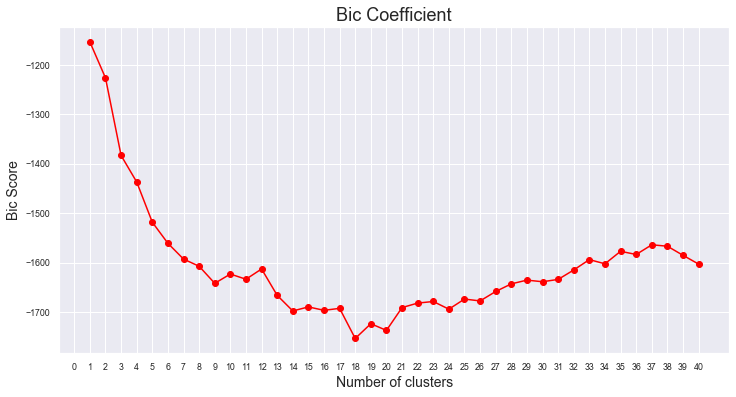

<Figure size 432x288 with 0 Axes>

In [14]:
###################################################################################################################
data_to_fit = df[['Norm_Lat', 'Norm_Long']]
###################################################################################################################
if (sampling_method == 'full') or (sampling_method == 'spherical') or (sampling_method == 'diag') or (sampling_method == 'tied'):
    gmms = mixture.GaussianMixture(n_components=1, covariance_type=sampling_method, n_init=5, max_iter=500, random_state=0)
    print(gmms.fit(data_to_fit))
    print("Bic Score Given 1 Component: ", round(gmms.bic(data_to_fit), 5))
    ###################################################################################################################
    # Fitting multiple GMMs algorithms and storing the values in an empty list
    SSE = []
    for cluster in range(1, 41):
        gmms = mixture.GaussianMixture(n_components=cluster, covariance_type=sampling_method, n_init=5, max_iter=500, random_state=0)
        gmms.fit_predict(data_to_fit)
        SSE.append(gmms.bic(data_to_fit))
    # Converting the results into a dataframe and plotting them
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    frame = pd.DataFrame({'Cluster':range(1, 41), 'SSE':SSE})
    ax.plot(frame['Cluster'], frame['SSE'], color="red", marker='o')
    ax.set_title('Bic Coefficient', size=18)
    ax.set_ylabel('Bic Score', size=14)
    ax.set_xlabel('Number of clusters', size=14)
    ax.xaxis.set_ticks(np.arange(0.0, 41.0, 1.0))
    fig.savefig(path_db + '/Sp_Bic_Coefficient.png', bbox_inches='tight')
    plt.show()
    plt.clf()
###################################################################################################################
elif (sampling_method == 'K-means random state 9307') or (sampling_method == 'K-means random state 0'):
    kmeans = KMeans(n_clusters=1, n_jobs=5, n_init=10, init='k-means++', max_iter=300, tol=0.0001)
    print(kmeans.fit(data_to_fit))
    print("Inertia Given 1 Cluster: ", round(kmeans.inertia_, 5))
    ###################################################################################################################
    # Fitting multiple K-means algorithms and storing the values in an empty list
    SSE = []
    for cluster in range(1, 41):
        kmeans = KMeans(n_clusters=cluster, n_jobs=5, n_init=10, init='k-means++', max_iter=300, tol=0.0001)
        kmeans.fit_predict(data_to_fit)
        SSE.append(kmeans.inertia_)
    # Converting the results into a dataframe and plotting them
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    frame = pd.DataFrame({'Cluster':range(1, 41), 'SSE':SSE})
    ax.plot(frame['Cluster'], frame['SSE'], color="red", marker='o')
    ax.set_title('Elbow Curve', size=18)
    ax.set_ylabel('Inertia', size=14)
    ax.set_xlabel('Number of clusters', size=14)
    ax.xaxis.set_ticks(np.arange(0.0, 41.0, 1.0))
    fig.savefig(path_db + '/Sp_Elbow_Curve.png', bbox_inches='tight')
    plt.show()
    plt.clf()    
###################################################################################################################
elif sampling_method == 'Random':
    print("Random Sampling --> So no clusters")
###################################################################################################################

#### Plot the derive clusters
* With GMM, the lowest Bic (Bayesian criterion information) Score indicate the optimal number of clusters/components to use for that sampling method
* For K-means clustering, the point that there isn't any sufficient decrease in the elbow curve is the point that we can indicate as the optimal number of clusters

1     128
16    125
9     124
8      96
2      87
10     86
17     79
6      62
14     56
0      24
7      23
4      23
11     19
12     19
5      18
15     15
13      8
3       8
Name: cluster, dtype: int64


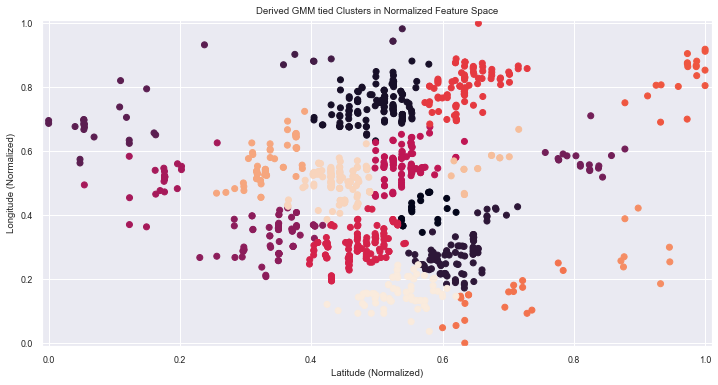

In [15]:
###################################################################################################################
# Fit a Gaussian Mixture Model with n-components and or K-means Clustering Model with n-clusters
if sampling_method == 'full':       n_componentss = 16 # i.e., the number of components with the lowest bic
if sampling_method == 'spherical':  n_componentss = 14 # i.e., the number of components with the lowest bic
if sampling_method == 'diag':       n_componentss = 16 # i.e., the number of components with the lowest bic
if sampling_method == 'tied':       n_componentss = 18 # i.e., the number of components with the lowest bic
if sampling_method == 'K-means random state 9307':  n_clusters = 20
if sampling_method == 'K-means random state 0':     n_clusters = 20
###################################################################################################################
if (sampling_method == 'full') or (sampling_method == 'spherical') or (sampling_method == 'diag') or (sampling_method == 'tied'):
    ###################################################################################################################
    gmms = mixture.GaussianMixture(n_components=n_componentss, covariance_type=sampling_method, n_init=5, max_iter=500, random_state=0)
    gmms.fit(data_to_fit)
    df['cluster'] = gmms.predict(data_to_fit)
    ###################################################################################################################
    df = df.sort_values('cluster', ascending=True)
    df = df.reset_index(drop=True)
    print(df['cluster'].value_counts(sort=True))
    ###################################################################################################################
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    categories = np.unique(df['cluster'])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))
    df["color"] = df['cluster'].apply(lambda x: colordict[x])
    ax.scatter(df['Norm_Lat'], df['Norm_Long'], c=df['color'])
    ######################################################################
    ax.set_title('Derived GMM ' + str(sampling_method) + ' Clusters in Normalized Feature Space')
    ax.set_xlabel('Latitude (Normalized)')
    ax.set_ylabel('Longitude (Normalized)')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ###################################################################################################################
    fig.savefig(path_db + '/Sp_Clustering.png', bbox_inches='tight')
    plt.show()
###################################################################################################################
elif (sampling_method == 'K-means random state 9307'):
    ###################################################################################################################
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=5, n_init=10, init='k-means++', max_iter=5000, tol=0.000001, random_state=9307)
    kmeans.fit(data_to_fit)
    Kmeans_cluster_center_array = kmeans.cluster_centers_
    df['cluster'] = kmeans.predict(data_to_fit)
    ###################################################################################################################
    df = df.sort_values('cluster', ascending=True)
    df = df.reset_index(drop=True)
    print(df['cluster'].value_counts(sort=True))
    ###################################################################################################################
    points = np.vstack([Kmeans_cluster_center_array[:, 0], Kmeans_cluster_center_array[:, 1]]).transpose()
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, line_alpha=0.6, line_colors='green', show_vertices=False, line_width=2)
    ax = fig.add_subplot(1, 1, 1)
    ######################################################################
    categories = np.unique(df['cluster'])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))
    df["color"] = df['cluster'].apply(lambda x: colordict[x])
    ax.scatter(df['Norm_Lat'], df['Norm_Long'], c=df['color'])
    ######################################################################
    i = 0
    while i < len(Kmeans_cluster_center_array):
        ax.scatter(Kmeans_cluster_center_array[i, 0], Kmeans_cluster_center_array[i, 1], s=150, marker='o', linewidths=1.0, edgecolors="black")
        plt.text(Kmeans_cluster_center_array[i, 0], Kmeans_cluster_center_array[i, 1], str(i+1), horizontalalignment='center', verticalalignment='center', size=7.5)
        i += 1
    ######################################################################
    ax.set_title('Derived K-means Clusters with Random State 9307 in Normalized Feature Space')
    ax.set_xlabel('Latitude (Normalized)')
    ax.set_ylabel('Longitude (Normalized)')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ###################################################################################################################
    fig.savefig(path_db + '/Sp_Clustering.png', bbox_inches='tight')
    plt.show()
###################################################################################################################
elif (sampling_method == 'K-means random state 0'):
    ###################################################################################################################
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=5, n_init=10, init='k-means++', max_iter=5000, tol=0.000001, random_state=0)
    kmeans.fit(data_to_fit)
    Kmeans_cluster_center_array = kmeans.cluster_centers_
    df['cluster'] = kmeans.predict(data_to_fit)
    ###################################################################################################################
    df = df.sort_values('cluster', ascending=True)
    df = df.reset_index(drop=True)
    print(df['cluster'].value_counts(sort=True))
    ###################################################################################################################
    points = np.vstack([Kmeans_cluster_center_array[:, 0], Kmeans_cluster_center_array[:, 1]]).transpose()
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, line_alpha=0.6, line_colors='green', show_vertices=False, line_width=2)
    ax = fig.add_subplot(1, 1, 1)
    ######################################################################
    categories = np.unique(df['cluster'])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))
    df["color"] = df['cluster'].apply(lambda x: colordict[x])
    ax.scatter(df['Norm_Lat'], df['Norm_Long'], c=df['color'])
    ######################################################################
    i = 0
    while i < len(Kmeans_cluster_center_array):
        ax.scatter(Kmeans_cluster_center_array[i, 0], Kmeans_cluster_center_array[i, 1], s=150, marker='o', linewidths=1.0, edgecolors="black")
        plt.text(Kmeans_cluster_center_array[i, 0], Kmeans_cluster_center_array[i, 1], str(i+1), horizontalalignment='center', verticalalignment='center', size=7.5)
        i += 1
    ######################################################################
    ax.set_title('Derived K-means Clusters with Random State 0 in Normalized Feature Space')
    ax.set_xlabel('Latitude (Normalized)')
    ax.set_ylabel('Longitude (Normalized)')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ###################################################################################################################
    fig.savefig(path_db + '/Sp_Clustering.png', bbox_inches='tight')
    plt.show()
###################################################################################################################
elif sampling_method == 'Random':
    print("Random Sampling --> So no clusters")
###################################################################################################################

#### Begin generating training and testing datasets with the optimal number of clusters to sample from

In [16]:
###################################################################################################################
type_of_cluster = 'cluster'
###################################################################################################################
if sampling_method == 'Random':
    ArrayVals = df
    print("Random Sampling --> So no clusters")
###################################################################################################################
if (sampling_method == 'K-means random state 9307') or (sampling_method == 'K-means random state 0'):
    df_00 = df.drop(df[(df[type_of_cluster] != 0)].index)
    df_01 = df.drop(df[(df[type_of_cluster] != 1)].index)
    df_02 = df.drop(df[(df[type_of_cluster] != 2)].index)
    df_03 = df.drop(df[(df[type_of_cluster] != 3)].index)
    df_04 = df.drop(df[(df[type_of_cluster] != 4)].index)
    df_05 = df.drop(df[(df[type_of_cluster] != 5)].index)
    df_06 = df.drop(df[(df[type_of_cluster] != 6)].index)
    df_07 = df.drop(df[(df[type_of_cluster] != 7)].index)
    df_08 = df.drop(df[(df[type_of_cluster] != 8)].index)
    df_09 = df.drop(df[(df[type_of_cluster] != 9)].index)
    df_10 = df.drop(df[(df[type_of_cluster] != 10)].index)
    df_11 = df.drop(df[(df[type_of_cluster] != 11)].index)
    df_12 = df.drop(df[(df[type_of_cluster] != 12)].index)
    df_13 = df.drop(df[(df[type_of_cluster] != 13)].index)
    df_14 = df.drop(df[(df[type_of_cluster] != 14)].index)
    df_15 = df.drop(df[(df[type_of_cluster] != 15)].index)
    df_16 = df.drop(df[(df[type_of_cluster] != 16)].index)
    df_17 = df.drop(df[(df[type_of_cluster] != 17)].index)
    df_18 = df.drop(df[(df[type_of_cluster] != 18)].index)
    df_19 = df.drop(df[(df[type_of_cluster] != 19)].index)
    ArrayVals = [df_00, df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19]
    print("Cluster 00: ", df_00.shape)
    print("Cluster 01: ", df_01.shape)
    print("Cluster 02: ", df_02.shape)
    print("Cluster 03: ", df_03.shape)
    print("Cluster 04: ", df_04.shape)
    print("Cluster 05: ", df_05.shape)
    print("Cluster 06: ", df_06.shape)
    print("Cluster 07: ", df_07.shape)
    print("Cluster 08: ", df_08.shape)
    print("Cluster 09: ", df_09.shape)
    print("Cluster 10: ", df_10.shape)
    print("Cluster 11: ", df_11.shape)
    print("Cluster 12: ", df_12.shape)
    print("Cluster 13: ", df_13.shape)
    print("Cluster 14: ", df_14.shape)
    print("Cluster 15: ", df_15.shape)
    print("Cluster 16: ", df_16.shape)
    print("Cluster 17: ", df_17.shape)
    print("Cluster 18: ", df_18.shape)
    print("Cluster 19: ", df_19.shape)
###################################################################################################################
if sampling_method == 'full':
    df_00 = df.drop(df[(df[type_of_cluster] != 0)].index)
    df_01 = df.drop(df[(df[type_of_cluster] != 1)].index)
    df_02 = df.drop(df[(df[type_of_cluster] != 2)].index)
    df_03 = df.drop(df[(df[type_of_cluster] != 3)].index)
    df_04 = df.drop(df[(df[type_of_cluster] != 4)].index)
    df_05 = df.drop(df[(df[type_of_cluster] != 5)].index)
    df_06 = df.drop(df[(df[type_of_cluster] != 6)].index)
    df_07 = df.drop(df[(df[type_of_cluster] != 7)].index)
    df_08 = df.drop(df[(df[type_of_cluster] != 8)].index)
    df_09 = df.drop(df[(df[type_of_cluster] != 9)].index)
    df_10 = df.drop(df[(df[type_of_cluster] != 10)].index)
    df_11 = df.drop(df[(df[type_of_cluster] != 11)].index)
    df_12 = df.drop(df[(df[type_of_cluster] != 12)].index)
    df_13 = df.drop(df[(df[type_of_cluster] != 13)].index)
    df_14 = df.drop(df[(df[type_of_cluster] != 14)].index)
    df_15 = df.drop(df[(df[type_of_cluster] != 15)].index)
    ArrayVals = [df_00, df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15]
    print("Cluster 00: ", df_00.shape)
    print("Cluster 01: ", df_01.shape)
    print("Cluster 02: ", df_02.shape)
    print("Cluster 03: ", df_03.shape)
    print("Cluster 04: ", df_04.shape)
    print("Cluster 05: ", df_05.shape)
    print("Cluster 06: ", df_06.shape)
    print("Cluster 07: ", df_07.shape)
    print("Cluster 08: ", df_08.shape)
    print("Cluster 09: ", df_09.shape)
    print("Cluster 10: ", df_10.shape)
    print("Cluster 11: ", df_11.shape)
    print("Cluster 12: ", df_12.shape)
    print("Cluster 13: ", df_13.shape)
    print("Cluster 14: ", df_14.shape)
    print("Cluster 15: ", df_15.shape)
###################################################################################################################
if sampling_method == 'spherical':
    df_00 = df.drop(df[(df[type_of_cluster] != 0)].index)
    df_01 = df.drop(df[(df[type_of_cluster] != 1)].index)
    df_02 = df.drop(df[(df[type_of_cluster] != 2)].index)
    df_03 = df.drop(df[(df[type_of_cluster] != 3)].index)
    df_04 = df.drop(df[(df[type_of_cluster] != 4)].index)
    df_05 = df.drop(df[(df[type_of_cluster] != 5)].index)
    df_06 = df.drop(df[(df[type_of_cluster] != 6)].index)
    df_07 = df.drop(df[(df[type_of_cluster] != 7)].index)
    df_08 = df.drop(df[(df[type_of_cluster] != 8)].index)
    df_09 = df.drop(df[(df[type_of_cluster] != 9)].index)
    df_10 = df.drop(df[(df[type_of_cluster] != 10)].index)
    df_11 = df.drop(df[(df[type_of_cluster] != 11)].index)
    df_12 = df.drop(df[(df[type_of_cluster] != 12)].index)
    df_13 = df.drop(df[(df[type_of_cluster] != 13)].index)
    ArrayVals = [df_00, df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_13]
    print("Cluster 00: ", df_00.shape)
    print("Cluster 01: ", df_01.shape)
    print("Cluster 02: ", df_02.shape)
    print("Cluster 03: ", df_03.shape)
    print("Cluster 04: ", df_04.shape)
    print("Cluster 05: ", df_05.shape)
    print("Cluster 06: ", df_06.shape)
    print("Cluster 07: ", df_07.shape)
    print("Cluster 08: ", df_08.shape)
    print("Cluster 09: ", df_09.shape)
    print("Cluster 10: ", df_10.shape)
    print("Cluster 11: ", df_11.shape)
    print("Cluster 12: ", df_12.shape)
    print("Cluster 13: ", df_13.shape)
###################################################################################################################
if sampling_method == 'diag':
    df_00 = df.drop(df[(df[type_of_cluster] != 0)].index)
    df_01 = df.drop(df[(df[type_of_cluster] != 1)].index)
    df_02 = df.drop(df[(df[type_of_cluster] != 2)].index)
    df_03 = df.drop(df[(df[type_of_cluster] != 3)].index)
    df_04 = df.drop(df[(df[type_of_cluster] != 4)].index)
    df_05 = df.drop(df[(df[type_of_cluster] != 5)].index)
    df_06 = df.drop(df[(df[type_of_cluster] != 6)].index)
    df_07 = df.drop(df[(df[type_of_cluster] != 7)].index)
    df_08 = df.drop(df[(df[type_of_cluster] != 8)].index)
    df_09 = df.drop(df[(df[type_of_cluster] != 9)].index)
    df_10 = df.drop(df[(df[type_of_cluster] != 10)].index)
    df_11 = df.drop(df[(df[type_of_cluster] != 11)].index)
    df_12 = df.drop(df[(df[type_of_cluster] != 12)].index)
    df_13 = df.drop(df[(df[type_of_cluster] != 13)].index)
    df_14 = df.drop(df[(df[type_of_cluster] != 14)].index)
    df_15 = df.drop(df[(df[type_of_cluster] != 15)].index)
    ArrayVals = [df_00, df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15]
    print("Cluster 00: ", df_00.shape)
    print("Cluster 01: ", df_01.shape)
    print("Cluster 02: ", df_02.shape)
    print("Cluster 03: ", df_03.shape)
    print("Cluster 04: ", df_04.shape)
    print("Cluster 05: ", df_05.shape)
    print("Cluster 06: ", df_06.shape)
    print("Cluster 07: ", df_07.shape)
    print("Cluster 08: ", df_08.shape)
    print("Cluster 09: ", df_09.shape)
    print("Cluster 10: ", df_10.shape)
    print("Cluster 11: ", df_11.shape)
    print("Cluster 12: ", df_12.shape)
    print("Cluster 13: ", df_13.shape)
    print("Cluster 14: ", df_14.shape)
    print("Cluster 15: ", df_15.shape)
###################################################################################################################
if sampling_method == 'tied':
    df_00 = df.drop(df[(df[type_of_cluster] != 0)].index)
    df_01 = df.drop(df[(df[type_of_cluster] != 1)].index)
    df_02 = df.drop(df[(df[type_of_cluster] != 2)].index)
    df_03 = df.drop(df[(df[type_of_cluster] != 3)].index)
    df_04 = df.drop(df[(df[type_of_cluster] != 4)].index)
    df_05 = df.drop(df[(df[type_of_cluster] != 5)].index)
    df_06 = df.drop(df[(df[type_of_cluster] != 6)].index)
    df_07 = df.drop(df[(df[type_of_cluster] != 7)].index)
    df_08 = df.drop(df[(df[type_of_cluster] != 8)].index)
    df_09 = df.drop(df[(df[type_of_cluster] != 9)].index)
    df_10 = df.drop(df[(df[type_of_cluster] != 10)].index)
    df_11 = df.drop(df[(df[type_of_cluster] != 11)].index)
    df_12 = df.drop(df[(df[type_of_cluster] != 12)].index)
    df_13 = df.drop(df[(df[type_of_cluster] != 13)].index)
    df_14 = df.drop(df[(df[type_of_cluster] != 14)].index)
    df_15 = df.drop(df[(df[type_of_cluster] != 15)].index)
    df_16 = df.drop(df[(df[type_of_cluster] != 16)].index)
    df_17 = df.drop(df[(df[type_of_cluster] != 17)].index)
    ArrayVals = [df_00, df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17]
    print("Cluster 00: ", df_00.shape)
    print("Cluster 01: ", df_01.shape)
    print("Cluster 02: ", df_02.shape)
    print("Cluster 03: ", df_03.shape)
    print("Cluster 04: ", df_04.shape)
    print("Cluster 05: ", df_05.shape)
    print("Cluster 06: ", df_06.shape)
    print("Cluster 07: ", df_07.shape)
    print("Cluster 08: ", df_08.shape)
    print("Cluster 09: ", df_09.shape)
    print("Cluster 10: ", df_10.shape)
    print("Cluster 11: ", df_11.shape)
    print("Cluster 12: ", df_12.shape)
    print("Cluster 13: ", df_13.shape)
    print("Cluster 14: ", df_14.shape)
    print("Cluster 15: ", df_15.shape)
    print("Cluster 16: ", df_16.shape)
    print("Cluster 17: ", df_17.shape)
###################################################################################################################

Cluster 00:  (24, 13)
Cluster 01:  (128, 13)
Cluster 02:  (87, 13)
Cluster 03:  (8, 13)
Cluster 04:  (23, 13)
Cluster 05:  (18, 13)
Cluster 06:  (62, 13)
Cluster 07:  (23, 13)
Cluster 08:  (96, 13)
Cluster 09:  (124, 13)
Cluster 10:  (86, 13)
Cluster 11:  (19, 13)
Cluster 12:  (19, 13)
Cluster 13:  (8, 13)
Cluster 14:  (56, 13)
Cluster 15:  (15, 13)
Cluster 16:  (125, 13)
Cluster 17:  (79, 13)


#### Finalize training and testing datasets for a given sampling method
What I do here to finalize the training and testing dataset for a given sampling method is to randomly sample from a given cluster, where 70% is taken for training and the remaining 30% left in each cluster is summed together, and is used for validating/testing the trained machine learning model.

In [19]:
###################################################################################################################
def training_testing_datasets1(rnd_state, shuffle_bool, test_size, ArrayVals, sample_method):
    """
    :param rnd_state: The train/test random state split
    :param shuffle_bool: Whether to shuffle of the data or not --> this should be set to True
    :param test_size: The train/test split size
    :param ArrayVals: The array that contains the data belonging to each cluster
    :param sample_method: The chosen method to derive the clusters
    :return: The finalized training and testing datasets
    """
    ###################################################################################################################
    rnd_state = rnd_state
    shuffle_bool = shuffle_bool
    test_size = test_size
    if sample_method == 'Random':
        ###################################################################################################################
        traindata_00, testdata_00 = train_test_split(ArrayVals, test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        ###################################################################################################################
        columns_train = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long']
        columns_test = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long']
        ###################################################################################################################
        traindata_00_array = np.asarray(traindata_00.to_numpy()); testdata_00_array = np.asarray(testdata_00.to_numpy())
        ###################################################################################################################
        training_data1 = np.vstack([traindata_00_array])
        training_data_new1 = pd.DataFrame(training_data1, columns=columns_train)
        training_data_new1 = training_data_new1.drop(columns=['Norm_Lat', 'Norm_Long'])
        ###################################################################################################################
        testing_data1 = np.vstack([testdata_00_array])
        testing_data_new1 = pd.DataFrame(testing_data1, columns=columns_test)
        testing_data_new1 = testing_data_new1.drop(columns=['Norm_Lat', 'Norm_Long'])
        ###################################################################################################################
    if (sample_method == 'K-means random state 9307') or (sample_method == 'K-means random state 0'):
        ###################################################################################################################
        traindata_00, testdata_00 = train_test_split(ArrayVals[0], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_01, testdata_01 = train_test_split(ArrayVals[1], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_02, testdata_02 = train_test_split(ArrayVals[2], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_03, testdata_03 = train_test_split(ArrayVals[3], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_04, testdata_04 = train_test_split(ArrayVals[4], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_05, testdata_05 = train_test_split(ArrayVals[5], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_06, testdata_06 = train_test_split(ArrayVals[6], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_07, testdata_07 = train_test_split(ArrayVals[7], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_08, testdata_08 = train_test_split(ArrayVals[8], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_09, testdata_09 = train_test_split(ArrayVals[9], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_10, testdata_10 = train_test_split(ArrayVals[10], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_11, testdata_11 = train_test_split(ArrayVals[11], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_12, testdata_12 = train_test_split(ArrayVals[12], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_13, testdata_13 = train_test_split(ArrayVals[13], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_14, testdata_14 = train_test_split(ArrayVals[14], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_15, testdata_15 = train_test_split(ArrayVals[15], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_16, testdata_16 = train_test_split(ArrayVals[16], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_17, testdata_17 = train_test_split(ArrayVals[17], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_18, testdata_18 = train_test_split(ArrayVals[18], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_19, testdata_19 = train_test_split(ArrayVals[19], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        ###################################################################################################################
        columns_train = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        columns_test = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        ###################################################################################################################
        traindata_00_array = np.asarray(traindata_00.to_numpy()); testdata_00_array = np.asarray(testdata_00.to_numpy())
        traindata_01_array = np.asarray(traindata_01.to_numpy()); testdata_01_array = np.asarray(testdata_01.to_numpy())
        traindata_02_array = np.asarray(traindata_02.to_numpy()); testdata_02_array = np.asarray(testdata_02.to_numpy())
        traindata_03_array = np.asarray(traindata_03.to_numpy()); testdata_03_array = np.asarray(testdata_03.to_numpy())
        traindata_04_array = np.asarray(traindata_04.to_numpy()); testdata_04_array = np.asarray(testdata_04.to_numpy())
        traindata_05_array = np.asarray(traindata_05.to_numpy()); testdata_05_array = np.asarray(testdata_05.to_numpy())
        traindata_06_array = np.asarray(traindata_06.to_numpy()); testdata_06_array = np.asarray(testdata_06.to_numpy())
        traindata_07_array = np.asarray(traindata_07.to_numpy()); testdata_07_array = np.asarray(testdata_07.to_numpy())
        traindata_08_array = np.asarray(traindata_08.to_numpy()); testdata_08_array = np.asarray(testdata_08.to_numpy())
        traindata_09_array = np.asarray(traindata_09.to_numpy()); testdata_09_array = np.asarray(testdata_09.to_numpy())
        traindata_10_array = np.asarray(traindata_10.to_numpy()); testdata_10_array = np.asarray(testdata_10.to_numpy())
        traindata_11_array = np.asarray(traindata_11.to_numpy()); testdata_11_array = np.asarray(testdata_11.to_numpy())
        traindata_12_array = np.asarray(traindata_12.to_numpy()); testdata_12_array = np.asarray(testdata_12.to_numpy())
        traindata_13_array = np.asarray(traindata_13.to_numpy()); testdata_13_array = np.asarray(testdata_13.to_numpy())
        traindata_14_array = np.asarray(traindata_14.to_numpy()); testdata_14_array = np.asarray(testdata_14.to_numpy())
        traindata_15_array = np.asarray(traindata_15.to_numpy()); testdata_15_array = np.asarray(testdata_15.to_numpy())
        traindata_16_array = np.asarray(traindata_16.to_numpy()); testdata_16_array = np.asarray(testdata_16.to_numpy())
        traindata_17_array = np.asarray(traindata_17.to_numpy()); testdata_17_array = np.asarray(testdata_17.to_numpy())
        traindata_18_array = np.asarray(traindata_18.to_numpy()); testdata_18_array = np.asarray(testdata_18.to_numpy())
        traindata_19_array = np.asarray(traindata_19.to_numpy()); testdata_19_array = np.asarray(testdata_19.to_numpy())
        ###################################################################################################################
        training_data1 = np.vstack([traindata_00_array, traindata_01_array, traindata_02_array, traindata_03_array, traindata_04_array, traindata_05_array, traindata_06_array, traindata_07_array, traindata_08_array, traindata_09_array, traindata_10_array, traindata_11_array, traindata_12_array, traindata_13_array, traindata_14_array, traindata_15_array, traindata_16_array, traindata_17_array, traindata_18_array, traindata_19_array])
        training_data_new1 = pd.DataFrame(training_data1, columns=columns_train)
        training_data_new1 = training_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
        testing_data1 = np.vstack([testdata_00_array, testdata_01_array, testdata_02_array, testdata_03_array, testdata_04_array, testdata_05_array, testdata_06_array, testdata_07_array, testdata_08_array, testdata_09_array, testdata_10_array, testdata_11_array, testdata_12_array, testdata_13_array, testdata_14_array, testdata_15_array, testdata_16_array, testdata_17_array, testdata_18_array, testdata_19_array])
        testing_data_new1 = pd.DataFrame(testing_data1, columns=columns_test)
        testing_data_new1 = testing_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
    if sample_method == 'full':
        ###################################################################################################################
        traindata_00, testdata_00 = train_test_split(ArrayVals[0], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_01, testdata_01 = train_test_split(ArrayVals[1], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_02, testdata_02 = train_test_split(ArrayVals[2], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_03, testdata_03 = train_test_split(ArrayVals[3], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_04, testdata_04 = train_test_split(ArrayVals[4], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_05, testdata_05 = train_test_split(ArrayVals[5], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_06, testdata_06 = train_test_split(ArrayVals[6], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_07, testdata_07 = train_test_split(ArrayVals[7], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_08, testdata_08 = train_test_split(ArrayVals[8], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_09, testdata_09 = train_test_split(ArrayVals[9], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_10, testdata_10 = train_test_split(ArrayVals[10], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_11, testdata_11 = train_test_split(ArrayVals[11], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_12, testdata_12 = train_test_split(ArrayVals[12], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_13, testdata_13 = train_test_split(ArrayVals[13], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_14, testdata_14 = train_test_split(ArrayVals[14], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_15, testdata_15 = train_test_split(ArrayVals[15], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        ###################################################################################################################
        columns_train = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        columns_test = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        ###################################################################################################################
        traindata_00_array = np.asarray(traindata_00.to_numpy()); testdata_00_array = np.asarray(testdata_00.to_numpy())
        traindata_01_array = np.asarray(traindata_01.to_numpy()); testdata_01_array = np.asarray(testdata_01.to_numpy())
        traindata_02_array = np.asarray(traindata_02.to_numpy()); testdata_02_array = np.asarray(testdata_02.to_numpy())
        traindata_03_array = np.asarray(traindata_03.to_numpy()); testdata_03_array = np.asarray(testdata_03.to_numpy())
        traindata_04_array = np.asarray(traindata_04.to_numpy()); testdata_04_array = np.asarray(testdata_04.to_numpy())
        traindata_05_array = np.asarray(traindata_05.to_numpy()); testdata_05_array = np.asarray(testdata_05.to_numpy())
        traindata_06_array = np.asarray(traindata_06.to_numpy()); testdata_06_array = np.asarray(testdata_06.to_numpy())
        traindata_07_array = np.asarray(traindata_07.to_numpy()); testdata_07_array = np.asarray(testdata_07.to_numpy())
        traindata_08_array = np.asarray(traindata_08.to_numpy()); testdata_08_array = np.asarray(testdata_08.to_numpy())
        traindata_09_array = np.asarray(traindata_09.to_numpy()); testdata_09_array = np.asarray(testdata_09.to_numpy())
        traindata_10_array = np.asarray(traindata_10.to_numpy()); testdata_10_array = np.asarray(testdata_10.to_numpy())
        traindata_11_array = np.asarray(traindata_11.to_numpy()); testdata_11_array = np.asarray(testdata_11.to_numpy())
        traindata_12_array = np.asarray(traindata_12.to_numpy()); testdata_12_array = np.asarray(testdata_12.to_numpy())
        traindata_13_array = np.asarray(traindata_13.to_numpy()); testdata_13_array = np.asarray(testdata_13.to_numpy())
        traindata_14_array = np.asarray(traindata_14.to_numpy()); testdata_14_array = np.asarray(testdata_14.to_numpy())
        traindata_15_array = np.asarray(traindata_15.to_numpy()); testdata_15_array = np.asarray(testdata_15.to_numpy())
        ###################################################################################################################
        training_data1 = np.vstack([traindata_00_array, traindata_01_array, traindata_02_array, traindata_03_array, traindata_04_array, traindata_05_array, traindata_06_array, traindata_07_array, traindata_08_array, traindata_09_array, traindata_10_array, traindata_11_array, traindata_12_array, traindata_13_array, traindata_14_array, traindata_15_array])
        training_data_new1 = pd.DataFrame(training_data1, columns=columns_train)
        training_data_new1 = training_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
        testing_data1 = np.vstack([testdata_00_array, testdata_01_array, testdata_02_array, testdata_03_array, testdata_04_array, testdata_05_array, testdata_06_array, testdata_07_array, testdata_08_array, testdata_09_array, testdata_10_array, testdata_11_array, testdata_12_array, testdata_13_array, testdata_14_array, testdata_15_array])
        testing_data_new1 = pd.DataFrame(testing_data1, columns=columns_test)
        testing_data_new1 = testing_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
    if sample_method == 'spherical':
        ###################################################################################################################
        traindata_00, testdata_00 = train_test_split(ArrayVals[0], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_01, testdata_01 = train_test_split(ArrayVals[1], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_02, testdata_02 = train_test_split(ArrayVals[2], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_03, testdata_03 = train_test_split(ArrayVals[3], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_04, testdata_04 = train_test_split(ArrayVals[4], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_05, testdata_05 = train_test_split(ArrayVals[5], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_06, testdata_06 = train_test_split(ArrayVals[6], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_07, testdata_07 = train_test_split(ArrayVals[7], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_08, testdata_08 = train_test_split(ArrayVals[8], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_09, testdata_09 = train_test_split(ArrayVals[9], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_10, testdata_10 = train_test_split(ArrayVals[10], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_11, testdata_11 = train_test_split(ArrayVals[11], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_12, testdata_12 = train_test_split(ArrayVals[12], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_13, testdata_13 = train_test_split(ArrayVals[13], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        ###################################################################################################################
        columns_train = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        columns_test = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        ###################################################################################################################
        traindata_00_array = np.asarray(traindata_00.to_numpy()); testdata_00_array = np.asarray(testdata_00.to_numpy())
        traindata_01_array = np.asarray(traindata_01.to_numpy()); testdata_01_array = np.asarray(testdata_01.to_numpy())
        traindata_02_array = np.asarray(traindata_02.to_numpy()); testdata_02_array = np.asarray(testdata_02.to_numpy())
        traindata_03_array = np.asarray(traindata_03.to_numpy()); testdata_03_array = np.asarray(testdata_03.to_numpy())
        traindata_04_array = np.asarray(traindata_04.to_numpy()); testdata_04_array = np.asarray(testdata_04.to_numpy())
        traindata_05_array = np.asarray(traindata_05.to_numpy()); testdata_05_array = np.asarray(testdata_05.to_numpy())
        traindata_06_array = np.asarray(traindata_06.to_numpy()); testdata_06_array = np.asarray(testdata_06.to_numpy())
        traindata_07_array = np.asarray(traindata_07.to_numpy()); testdata_07_array = np.asarray(testdata_07.to_numpy())
        traindata_08_array = np.asarray(traindata_08.to_numpy()); testdata_08_array = np.asarray(testdata_08.to_numpy())
        traindata_09_array = np.asarray(traindata_09.to_numpy()); testdata_09_array = np.asarray(testdata_09.to_numpy())
        traindata_10_array = np.asarray(traindata_10.to_numpy()); testdata_10_array = np.asarray(testdata_10.to_numpy())
        traindata_11_array = np.asarray(traindata_11.to_numpy()); testdata_11_array = np.asarray(testdata_11.to_numpy())
        traindata_12_array = np.asarray(traindata_12.to_numpy()); testdata_12_array = np.asarray(testdata_12.to_numpy())
        traindata_13_array = np.asarray(traindata_13.to_numpy()); testdata_13_array = np.asarray(testdata_13.to_numpy())
        ###################################################################################################################
        training_data1 = np.vstack([traindata_00_array, traindata_01_array, traindata_02_array, traindata_03_array, traindata_04_array, traindata_05_array, traindata_06_array, traindata_07_array, traindata_08_array, traindata_09_array, traindata_10_array, traindata_11_array, traindata_12_array, traindata_13_array])
        training_data_new1 = pd.DataFrame(training_data1, columns=columns_train)
        training_data_new1 = training_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
        testing_data1 = np.vstack([testdata_00_array, testdata_01_array, testdata_02_array, testdata_03_array, testdata_04_array, testdata_05_array, testdata_06_array, testdata_07_array, testdata_08_array, testdata_09_array, testdata_10_array, testdata_11_array, testdata_12_array, testdata_13_array])
        testing_data_new1 = pd.DataFrame(testing_data1, columns=columns_test)
        testing_data_new1 = testing_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
    if sample_method == 'diag':
        ###################################################################################################################
        traindata_00, testdata_00 = train_test_split(ArrayVals[0], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_01, testdata_01 = train_test_split(ArrayVals[1], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_02, testdata_02 = train_test_split(ArrayVals[2], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_03, testdata_03 = train_test_split(ArrayVals[3], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_04, testdata_04 = train_test_split(ArrayVals[4], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_05, testdata_05 = train_test_split(ArrayVals[5], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_06, testdata_06 = train_test_split(ArrayVals[6], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_07, testdata_07 = train_test_split(ArrayVals[7], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_08, testdata_08 = train_test_split(ArrayVals[8], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_09, testdata_09 = train_test_split(ArrayVals[9], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_10, testdata_10 = train_test_split(ArrayVals[10], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_11, testdata_11 = train_test_split(ArrayVals[11], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_12, testdata_12 = train_test_split(ArrayVals[12], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_13, testdata_13 = train_test_split(ArrayVals[13], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_14, testdata_14 = train_test_split(ArrayVals[14], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_15, testdata_15 = train_test_split(ArrayVals[15], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        ###################################################################################################################
        columns_train = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        columns_test = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        ###################################################################################################################
        traindata_00_array = np.asarray(traindata_00.to_numpy()); testdata_00_array = np.asarray(testdata_00.to_numpy())
        traindata_01_array = np.asarray(traindata_01.to_numpy()); testdata_01_array = np.asarray(testdata_01.to_numpy())
        traindata_02_array = np.asarray(traindata_02.to_numpy()); testdata_02_array = np.asarray(testdata_02.to_numpy())
        traindata_03_array = np.asarray(traindata_03.to_numpy()); testdata_03_array = np.asarray(testdata_03.to_numpy())
        traindata_04_array = np.asarray(traindata_04.to_numpy()); testdata_04_array = np.asarray(testdata_04.to_numpy())
        traindata_05_array = np.asarray(traindata_05.to_numpy()); testdata_05_array = np.asarray(testdata_05.to_numpy())
        traindata_06_array = np.asarray(traindata_06.to_numpy()); testdata_06_array = np.asarray(testdata_06.to_numpy())
        traindata_07_array = np.asarray(traindata_07.to_numpy()); testdata_07_array = np.asarray(testdata_07.to_numpy())
        traindata_08_array = np.asarray(traindata_08.to_numpy()); testdata_08_array = np.asarray(testdata_08.to_numpy())
        traindata_09_array = np.asarray(traindata_09.to_numpy()); testdata_09_array = np.asarray(testdata_09.to_numpy())
        traindata_10_array = np.asarray(traindata_10.to_numpy()); testdata_10_array = np.asarray(testdata_10.to_numpy())
        traindata_11_array = np.asarray(traindata_11.to_numpy()); testdata_11_array = np.asarray(testdata_11.to_numpy())
        traindata_12_array = np.asarray(traindata_12.to_numpy()); testdata_12_array = np.asarray(testdata_12.to_numpy())
        traindata_13_array = np.asarray(traindata_13.to_numpy()); testdata_13_array = np.asarray(testdata_13.to_numpy())
        traindata_14_array = np.asarray(traindata_14.to_numpy()); testdata_14_array = np.asarray(testdata_14.to_numpy())
        traindata_15_array = np.asarray(traindata_15.to_numpy()); testdata_15_array = np.asarray(testdata_15.to_numpy())
        ###################################################################################################################
        training_data1 = np.vstack([traindata_00_array, traindata_01_array, traindata_02_array, traindata_03_array, traindata_04_array, traindata_05_array, traindata_06_array, traindata_07_array, traindata_08_array, traindata_09_array, traindata_10_array, traindata_11_array, traindata_12_array, traindata_13_array, traindata_14_array, traindata_15_array])
        training_data_new1 = pd.DataFrame(training_data1, columns=columns_train)
        training_data_new1 = training_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
        testing_data1 = np.vstack([testdata_00_array, testdata_01_array, testdata_02_array, testdata_03_array, testdata_04_array, testdata_05_array, testdata_06_array, testdata_07_array, testdata_08_array, testdata_09_array, testdata_10_array, testdata_11_array, testdata_12_array, testdata_13_array, testdata_14_array, testdata_15_array])
        testing_data_new1 = pd.DataFrame(testing_data1, columns=columns_test)
        testing_data_new1 = testing_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
    if sample_method == 'tied':
        ###################################################################################################################
        traindata_00, testdata_00 = train_test_split(ArrayVals[0], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_01, testdata_01 = train_test_split(ArrayVals[1], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_02, testdata_02 = train_test_split(ArrayVals[2], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_03, testdata_03 = train_test_split(ArrayVals[3], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_04, testdata_04 = train_test_split(ArrayVals[4], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_05, testdata_05 = train_test_split(ArrayVals[5], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_06, testdata_06 = train_test_split(ArrayVals[6], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_07, testdata_07 = train_test_split(ArrayVals[7], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_08, testdata_08 = train_test_split(ArrayVals[8], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_09, testdata_09 = train_test_split(ArrayVals[9], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_10, testdata_10 = train_test_split(ArrayVals[10], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_11, testdata_11 = train_test_split(ArrayVals[11], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_12, testdata_12 = train_test_split(ArrayVals[12], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_13, testdata_13 = train_test_split(ArrayVals[13], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_14, testdata_14 = train_test_split(ArrayVals[14], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_15, testdata_15 = train_test_split(ArrayVals[15], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_16, testdata_16 = train_test_split(ArrayVals[16], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        traindata_17, testdata_17 = train_test_split(ArrayVals[17], test_size=test_size, random_state=rnd_state, shuffle=shuffle_bool)
        ###################################################################################################################
        columns_train = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        columns_test = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Latitude', 'Longitude', 'Production', 'Norm_Lat', 'Norm_Long', 'cluster', 'color']
        ###################################################################################################################
        traindata_00_array = np.asarray(traindata_00.to_numpy()); testdata_00_array = np.asarray(testdata_00.to_numpy())
        traindata_01_array = np.asarray(traindata_01.to_numpy()); testdata_01_array = np.asarray(testdata_01.to_numpy())
        traindata_02_array = np.asarray(traindata_02.to_numpy()); testdata_02_array = np.asarray(testdata_02.to_numpy())
        traindata_03_array = np.asarray(traindata_03.to_numpy()); testdata_03_array = np.asarray(testdata_03.to_numpy())
        traindata_04_array = np.asarray(traindata_04.to_numpy()); testdata_04_array = np.asarray(testdata_04.to_numpy())
        traindata_05_array = np.asarray(traindata_05.to_numpy()); testdata_05_array = np.asarray(testdata_05.to_numpy())
        traindata_06_array = np.asarray(traindata_06.to_numpy()); testdata_06_array = np.asarray(testdata_06.to_numpy())
        traindata_07_array = np.asarray(traindata_07.to_numpy()); testdata_07_array = np.asarray(testdata_07.to_numpy())
        traindata_08_array = np.asarray(traindata_08.to_numpy()); testdata_08_array = np.asarray(testdata_08.to_numpy())
        traindata_09_array = np.asarray(traindata_09.to_numpy()); testdata_09_array = np.asarray(testdata_09.to_numpy())
        traindata_10_array = np.asarray(traindata_10.to_numpy()); testdata_10_array = np.asarray(testdata_10.to_numpy())
        traindata_11_array = np.asarray(traindata_11.to_numpy()); testdata_11_array = np.asarray(testdata_11.to_numpy())
        traindata_12_array = np.asarray(traindata_12.to_numpy()); testdata_12_array = np.asarray(testdata_12.to_numpy())
        traindata_13_array = np.asarray(traindata_13.to_numpy()); testdata_13_array = np.asarray(testdata_13.to_numpy())
        traindata_14_array = np.asarray(traindata_14.to_numpy()); testdata_14_array = np.asarray(testdata_14.to_numpy())
        traindata_15_array = np.asarray(traindata_15.to_numpy()); testdata_15_array = np.asarray(testdata_15.to_numpy())
        traindata_16_array = np.asarray(traindata_16.to_numpy()); testdata_16_array = np.asarray(testdata_16.to_numpy())
        traindata_17_array = np.asarray(traindata_17.to_numpy()); testdata_17_array = np.asarray(testdata_17.to_numpy())
        ###################################################################################################################
        training_data1 = np.vstack([traindata_00_array, traindata_01_array, traindata_02_array, traindata_03_array, traindata_04_array, traindata_05_array, traindata_06_array, traindata_07_array, traindata_08_array, traindata_09_array, traindata_10_array, traindata_11_array, traindata_12_array, traindata_13_array, traindata_14_array, traindata_15_array, traindata_16_array, traindata_17_array])
        training_data_new1 = pd.DataFrame(training_data1, columns=columns_train)
        training_data_new1 = training_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
        testing_data1 = np.vstack([testdata_00_array, testdata_01_array, testdata_02_array, testdata_03_array, testdata_04_array, testdata_05_array, testdata_06_array, testdata_07_array, testdata_08_array, testdata_09_array, testdata_10_array, testdata_11_array, testdata_12_array, testdata_13_array, testdata_14_array, testdata_15_array, testdata_16_array, testdata_17_array])
        testing_data_new1 = pd.DataFrame(testing_data1, columns=columns_test)
        testing_data_new1 = testing_data_new1.drop(columns=['Norm_Lat', 'Norm_Long', 'cluster', 'color'])
        ###################################################################################################################
    return training_data_new1, testing_data_new1
###################################################################################################################

#### Predict production using the *random forest* method given a chosen sampling method
Hyperparameters are tuned afterwards for each sampling method... Due to this being a synthetic dataset, and the fact that I find the optimal random state to sample from a given cluster or map area (i.e., for random sampling) and the random forest regressor random state for each method, the final machine learning model performance metrics that are produced are similar.

Note that the random forest regressor random state is the random state used within the random forest model to make sure that the bootstrapping method has the same randomization each time in order to build a tree. It also ensures that randomization for choosing a feature in order to determine the optimal split at a certain node is the same each time.

sampling_method:               tied
random_seed_sampling_split:    947
random_seed_rnd_ft_split:      609
max_depth:                     21
num_tree:                      37
max_features:                  3
Training RMSE: 0.96% , MAPE: 4.53% , Exp_var: 99.334% , R^2: 99.334%
Testing  RMSE: 0.903% , MAPE: 7.105%    , Exp_var: 99.354% , R^2: 99.325%


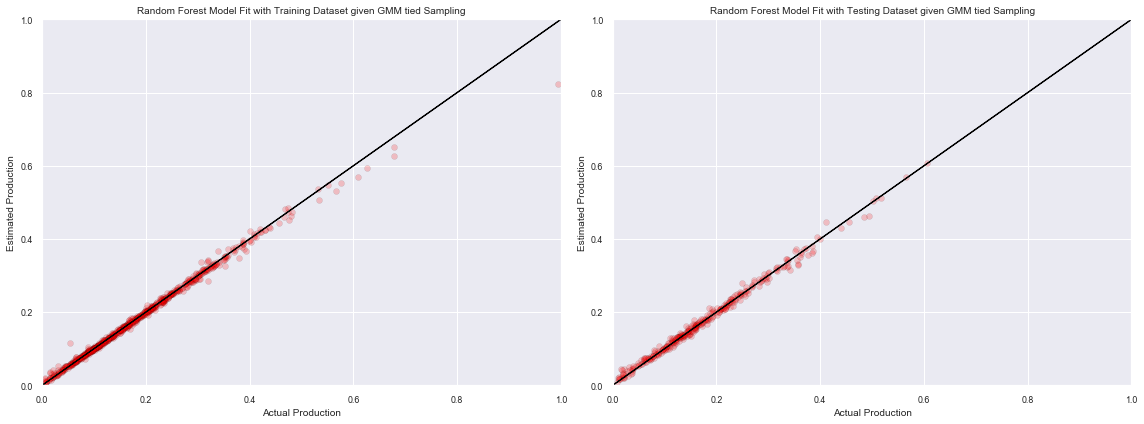

In [27]:
###################################################################################################################
pred_norm = df[['Por', 'Brittle', 'Latitude', 'Longitude']].copy()
response_norm = df[['Production']].copy()
###########################################
predictive_features_rf = np.array(['Por', 'Brittle', 'Latitude', 'Longitude'])
target_feature_rf = np.array(['Production'])
parameters_rf = np.hstack([predictive_features_rf, target_feature_rf])
###################################################################################################################
def random_forest_prod_prediction(split_seed, random_seed, max_depth, num_trees_rf, max_features, plot_print, plot_min, plot_max, print_str):
    """
    :param split_seed: The training and testing dataset random seed split
    :param random_seed: The random forest regressor random seed split
    :param max_depth: The maximum depth of the random forest
    :param num_trees_rf: The number of trees to average over the random forest
    :param max_features: The maximum number of features to consider to split on to create the random forest
    :param plot_print: Whether to plot the resulting graphs or not
    :param plot_min: The minimum x and y-axis values
    :param plot_max: The maximum x and y-axis values
    :param print_str: The text belonging to the sampling method used to complete the title of the plots
    :return: The resulting random forest model perfromance metrics
    """
    # Random Forest Hyperparameters
    max_depth = max_depth
    random_seed = random_seed
    num_trees_rf = num_trees_rf
    max_features = max_features

    # random states to choose from: 113, 618, or 4478
    training_data_new, testing_data_new = training_testing_datasets1(split_seed, True, 0.3, ArrayVals, sampling_method)
    traindata_rf = np.asarray(training_data_new[parameters_rf].to_numpy())
    testdata_rf = np.asarray(testing_data_new[parameters_rf].to_numpy())
    X_train = traindata_rf[:, :-1]; y_train = traindata_rf[:, -1]
    X_test = testdata_rf[:, :-1];   y_test = testdata_rf[:, -1]
    
    regressor_with_sampling = RandomForestRegressor(oob_score=True, max_depth=max_depth, random_state=random_seed, n_estimators=num_trees_rf, max_features=max_features)
    regressor_with_sampling.fit(X=X_train, y=y_train)
    y_pred_train = regressor_with_sampling.predict(X_train)
    y_pred_test = regressor_with_sampling.predict(X_test)

    rf_RMSE_train = float(np.sqrt(mean_squared_error(y_train, y_pred_train)) * 100)
    rf_mape_train = float(np.mean(mean_absolute_error(y_train, y_pred_train) / y_train) * 100)
    rf_Var_Explained_train = float(explained_variance_score(y_train, y_pred_train) * 100)
    rf_r2_train = float(r2_score(y_train, y_pred_train) * 100)
    rf_RMSE_test = float(np.sqrt(mean_squared_error(y_test, y_pred_test)) * 100)
    rf_mape_test = float(np.mean(mean_absolute_error(y_test, y_pred_test) / y_test) * 100)
    rf_Var_Explained_test = float(explained_variance_score(y_test, y_pred_test) * 100)
    rf_r2_test = float(r2_score(y_test, y_pred_test) * 100)
    
    str07 = 'Training RMSE: ' + str(round(rf_RMSE_train, 3)) + '% , MAPE: ' + str(round(rf_mape_train, 3)) + '% , Exp_var: ' + str(round(rf_Var_Explained_train, 3)) + '% , R^2: ' + str(round(rf_r2_train, 3)) + '%'
    str08 = 'Testing  RMSE: ' + str(round(rf_RMSE_test, 3)) + '% , MAPE: ' + str(round(rf_mape_test, 3)) + '%    , Exp_var: ' + str(round(rf_Var_Explained_test, 3)) + '% , R^2: ' + str(round(rf_r2_test, 3)) + '%'
    
    if plot_print == True:
        print(str07); print(str08)
        
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_pred_train, s=None, c='red', alpha=0.2, linewidths=0.3, edgecolors="black")
        plt.title('Random Forest Model Fit with Training Dataset given ' + str(print_str) + ' Sampling', size=10)
        plt.xlabel('Actual Production', size=10)
        plt.ylabel('Estimated Production', size=10)
        plt.xlim(plot_min, plot_max)
        plt.ylim(plot_min, plot_max)
        plt.arrow(plot_min, plot_min, plot_max, plot_max, width=0.001, color='black', head_length=5.0, head_width=0.0)
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_pred_test, s=None, c='red', alpha=0.2, linewidths=0.3, edgecolors="black")
        plt.title('Random Forest Model Fit with Testing Dataset given ' + str(print_str) + ' Sampling', size=10)
        plt.xlabel('Actual Production', size=10)
        plt.ylabel('Estimated Production', size=10)
        plt.xlim(plot_min, plot_max)
        plt.ylim(plot_min, plot_max)
        plt.arrow(plot_min, plot_min, plot_max, plot_max, width=0.001, color='black', head_length=5.0, head_width=0.0)
        plt.tight_layout()
        plt.savefig(path_db + '/RF_Final_Fit.png', bbox_inches='tight')
        plt.show()
    
    return rf_r2_test, rf_Var_Explained_test, rf_RMSE_test, rf_mape_test, str07, str08

###################################################################################################################
if sampling_method == 'Random':
    random_seed_sampling_split = 8987
    random_seed_rnd_ft_split = 5006
    max_depth = 16
    num_tree = 42
    max_features = 3
    print_str = 'Random'
    # Training RMSE: 0.943% , MAPE: 4.343%  , Exp_var: 99.343% , R^2: 99.343%
    # Testing  RMSE: 0.97%  , MAPE: 8.851%  , Exp_var: 99.259% , R^2: 99.257%
###################################################################################################################
if sampling_method == 'K-means random state 9307':
    random_seed_sampling_split = 3144
    random_seed_rnd_ft_split = 4921
    max_depth = 19
    num_tree = 29
    max_features = 3
    print_str = 'K-means random state 9307'
    # Training RMSE: 1.136% , MAPE: 4.731%  , Exp_var: 99.03%  , R^2: 99.03%
    # Testing  RMSE: 1.04%  , MAPE: 8.548%  , Exp_var: 99.206% , R^2: 99.183%
###################################################################################################################
if sampling_method == 'K-means random state 0':
    random_seed_sampling_split = 9339
    random_seed_rnd_ft_split = 7264
    max_depth = 21
    num_tree = 65
    max_features = 3
    print_str = 'K-means random state 0'
    # Training RMSE: 1.007% , MAPE: 4.406%  , Exp_var: 99.234% , R^2: 99.234%
    # Testing  RMSE: 1.014% , MAPE: 8.101%  , Exp_var: 99.249% , R^2: 99.233%
###################################################################################################################
if sampling_method == 'full':
    random_seed_sampling_split = 672
    random_seed_rnd_ft_split = 7858
    max_depth = 21
    num_tree = 32
    max_features = 3
    print_str = 'GMM full'
    # Training RMSE: 0.996% , MAPE: 4.505%  , Exp_var: 99.269% , R^2: 99.269%
    # Testing  RMSE: 1.057% , MAPE: 7.888%  , Exp_var: 99.15%  , R^2: 99.118%
###################################################################################################################
if sampling_method == 'spherical':
    random_seed_sampling_split = 6974
    random_seed_rnd_ft_split = 5131
    max_depth = 19
    num_tree = 30
    max_features = 3
    print_str = 'GMM spherical'    
    # Training RMSE: 0.942% , MAPE: 4.949%  , Exp_var: 99.385% , R^2: 99.385%
    # Testing  RMSE: 0.829% , MAPE: 6.124%  , Exp_var: 99.367% , R^2: 99.36%
###################################################################################################################
if sampling_method == 'diag':
    random_seed_sampling_split = 6877
    random_seed_rnd_ft_split = 6977
    max_depth = 19
    num_tree = 40
    max_features = 3
    print_str = 'GMM diag'
    # Training RMSE: 0.905% , MAPE: 4.406%  , Exp_var: 99.395% , R^2: 99.394%
    # Testing  RMSE: 0.918% , MAPE: 6.684%  , Exp_var: 99.349% , R^2: 99.342%
###################################################################################################################
if sampling_method == 'tied':
    random_seed_sampling_split = 947
    random_seed_rnd_ft_split = 609
    max_depth = 21
    num_tree = 37
    max_features = 3
    print_str = 'GMM tied'
    # Training RMSE: 0.96%  , MAPE: 4.53%   , Exp_var: 99.334% , R^2: 99.334%
    # Testing  RMSE: 0.903% , MAPE: 7.105%  , Exp_var: 99.354% , R^2: 99.325%
###################################################################################################################
str01 = 'sampling_method:               ' + str(sampling_method)
str02 = 'random_seed_sampling_split:    ' + str(random_seed_sampling_split)
str03 = 'random_seed_rnd_ft_split:      ' + str(random_seed_rnd_ft_split)
str04 = 'max_depth:                     ' + str(max_depth)
str05 = 'num_tree:                      ' + str(num_tree)
str06 = 'max_features:                  ' + str(max_features)
###################################################################################################################
print(str01); print(str02); print(str03); print(str04); print(str05); print(str06)
###################################################################################################################
r2_test, Var_Explained_test, RMSE_test, mape_test, str07, str08 = random_forest_prod_prediction(random_seed_sampling_split, random_seed_rnd_ft_split, max_depth, num_tree, max_features, True, 0, 1, print_str)
###################################################################################################################
output = pd.DataFrame([str01, str02, str03, str04, str05, str06, str07, str08])
output.columns = ["Results"]
output.to_csv(path_db + '/RF_Results.csv', sep='\t')
###################################################################################################################

#### For the random forest model, find the optimal random state for the training and testing split (i.e., the random state to sample from each of the derived clusters or the entire map area) and for the random forest regressor model given the chosen sampling method

In [24]:
###################################################################################################################
# Random Forest Hyperparameters
max_depth = max_depth
num_trees_rf = num_tree
##############################
run_sampling_split = True
run_test = False
##############################
rnd_sampling = random_seed_sampling_split
rnd_rnd_ft = random_seed_rnd_ft_split
###################################################################################################################
if run_test == True:
    rnd_seed_iter = np.arange(0, 51, 1)
else:
    rnd_seed_iter = np.arange(0, 10001, 1)
###################################################################################################################
fit_rnd_seed_r2value_test = []; fit_rnd_seed_exp_var_test = []; fit_rnd_seed_rmse_test = []; fit_rnd_seed_mape_test = []
###################################################################################################################
fit_rnd_seed_r2value_test_array = np.zeros((len(rnd_seed_iter), 1))
fit_rnd_seed_exp_var_test_array = np.zeros((len(rnd_seed_iter), 1))
fit_rnd_seed_rmse_test_array = np.zeros((len(rnd_seed_iter), 1))
fit_rnd_seed_mape_test_array = np.zeros((len(rnd_seed_iter), 1))
###################################################################################################################
index = 0
print('Complete of ' + str(index) + ': ', end =" ")
while index < len(rnd_seed_iter):
    rnd00 = rnd_seed_iter[index]
    if run_sampling_split == True:
        r2_test, Var_Explained_test, RMSE_test, mape_test, str07, str08 = random_forest_prod_prediction(rnd00, rnd_rnd_ft, max_depth, num_trees_rf, max_features, False, 0, 1, print_str)
    else:
        r2_test, Var_Explained_test, RMSE_test, mape_test, str07, str08 = random_forest_prod_prediction(rnd_sampling, rnd00, max_depth, num_trees_rf, max_features, False, 0, 1, print_str)        
    fit_rnd_seed_r2value_test.append([r2_test])
    fit_rnd_seed_exp_var_test.append([Var_Explained_test])
    fit_rnd_seed_rmse_test.append([RMSE_test])
    fit_rnd_seed_mape_test.append([mape_test])

    index += 1

    if run_test == True:
        if index % 10 == 0: print(str(index) + ', ', end =" ")
    else:
        if index % 1000 == 0: print(str(index) + ', ', end =" ")

fit_rnd_seed_r2value_test_array = np.append(fit_rnd_seed_r2value_test_array, fit_rnd_seed_r2value_test, axis=1)
fit_rnd_seed_exp_var_test_array = np.append(fit_rnd_seed_exp_var_test_array, fit_rnd_seed_exp_var_test, axis=1)
fit_rnd_seed_rmse_test_array = np.append(fit_rnd_seed_rmse_test_array, fit_rnd_seed_rmse_test, axis=1)
fit_rnd_seed_mape_test_array = np.append(fit_rnd_seed_mape_test_array, fit_rnd_seed_mape_test, axis=1)
fit_rnd_seed_r2value_test.clear()
fit_rnd_seed_exp_var_test.clear()
fit_rnd_seed_rmse_test.clear()
fit_rnd_seed_mape_test.clear()
fit_rnd_seed_r2value_test_ary = np.delete(fit_rnd_seed_r2value_test_array, 0, axis=1)
fit_rnd_seed_exp_var_test_ary = np.delete(fit_rnd_seed_exp_var_test_array, 0, axis=1)
fit_rnd_seed_rmse_test_ary = np.delete(fit_rnd_seed_rmse_test_array, 0, axis=1)
fit_rnd_seed_mape_test_ary = np.delete(fit_rnd_seed_mape_test_array, 0, axis=1)
fit_rnd_seed_r2value_test_ary = np.mean(fit_rnd_seed_r2value_test_ary, axis=1)
fit_rnd_seed_exp_var_test_ary = np.mean(fit_rnd_seed_exp_var_test_ary, axis=1)
fit_rnd_seed_rmse_test_ary = np.mean(fit_rnd_seed_rmse_test_ary, axis=1)
fit_rnd_seed_mape_test_ary = np.mean(fit_rnd_seed_mape_test_ary, axis=1)
###################################################################################################################
r2_max_rnd_seed = np.round(np.max(fit_rnd_seed_r2value_test_ary), 3)
exp_var_max_rnd_seed = np.round(np.max(fit_rnd_seed_exp_var_test_ary), 3)
rmse_min_rnd_seed = np.round(np.min(fit_rnd_seed_rmse_test_ary), 3)
mape_min_rnd_seed = np.round(np.min(fit_rnd_seed_mape_test_ary), 3)
###################################################################################################################
optimal_r2value_rnd_seed = [i for i, x in enumerate(fit_rnd_seed_r2value_test_ary) if x == np.max(fit_rnd_seed_r2value_test_ary)][0]
optimal_exp_var_rnd_seed = [i for i, x in enumerate(fit_rnd_seed_exp_var_test_ary) if x == np.max(fit_rnd_seed_exp_var_test_ary)][0]
optimal_rmse_rnd_seed = [i for i, x in enumerate(fit_rnd_seed_rmse_test_ary) if x == np.min(fit_rnd_seed_rmse_test_ary)][0]
optimal_mape_rnd_seed = [i for i, x in enumerate(fit_rnd_seed_mape_test_ary) if x == np.min(fit_rnd_seed_mape_test_ary)][0]
###################################################################################################################
df_hpt_rf = pd.DataFrame({'optimal random state':[rnd_seed_iter[optimal_r2value_rnd_seed], rnd_seed_iter[optimal_exp_var_rnd_seed], rnd_seed_iter[optimal_rmse_rnd_seed], rnd_seed_iter[optimal_mape_rnd_seed]],
                          'metric value':[r2_max_rnd_seed, exp_var_max_rnd_seed, rmse_min_rnd_seed, mape_min_rnd_seed]},
                          index = ['R$^2$ Value', 'Exp_Var Value', 'RMSE Value', 'MAPE Value'])
###################################################################################################################
df_hpt_rf.head()
###################################################################################################################

Complete of 0:  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,  10000,  

,optimal random state,metric value
R$^2$ Value,609,99.312
Exp_Var Value,609,99.337
RMSE Value,609,0.912
MAPE Value,609,7.165


#### Tune random forest hyperparameters given the particular sampling method
Hyperparameters are the following:
* __max_depth__: The depth of a given tree
* __num_tree__: The number of trees to average over
* __max_features__: The total number of features to consider when trying to find the optimal split

Here, we will find the optimal num_tree and max_depth, where max_features is set to 3 for each sampling method.

Note that having a large number of trees and or depth of a given tree isn't exactly always the best option because we can begin overfitting our model, which will hurt our machine learning testing performance, and can increase the computational time. So, we want to find just the right amount. That said, ensemble methods are built to reduce that risk of overfitting in the first place and maximum the reduction in model variance, but we can perform hyperparameter tuning in this manner (coded/shown below) to make sure we are achieving optimal results with no overfit to the data.

Complete of 45:  5,  10,  15,  20,  25,  30,  35,  40,  45,  

Complete of 200:  20,  40,  60,  80,  100,  120,  140,  160,  180,  200,  

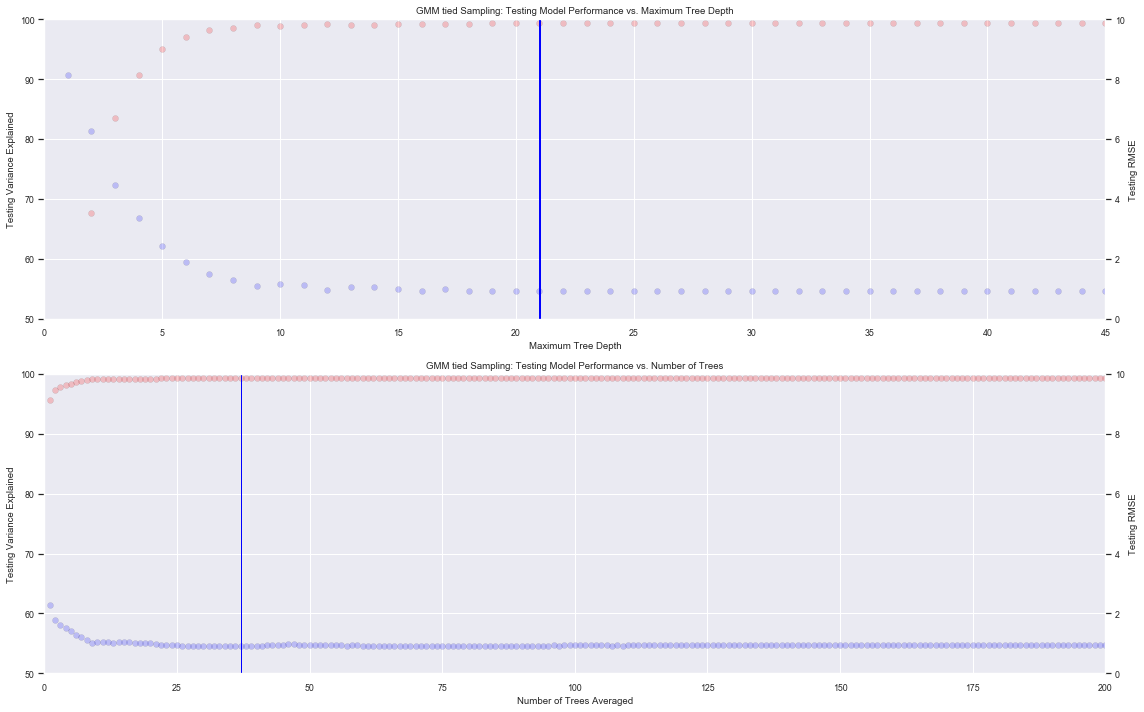

Results achieved by using min/max norm between -1.3875 and 1.3875, and between 0 and 1 for target feature
Results achieved with max_depth of:                  21
Results achieved with random forest random_seed of:  609
Results achieved with train-test random_seed of:     947
Results achieved with num_trees_rf of:               37
Results achieved with max_features of:               3

For the maximum tree depth, the maximum out of bag explained variance achieved was:        99.337%
For the number of trees averaged, the maximum out of bag explained variance achieved was:  99.354%

For the maximum tree depth, the optimal out of bag RMSE achieved was:        0.912%
For the number of trees averaged, the optimal out of bag RMSE achieved was:  0.903%


<Figure size 432x288 with 0 Axes>

In [26]:
###################################################################################################################
max_depths = np.linspace(1, 45, 45)         # Set the tree maximum tree depths to consider
fit_forests = []
oob_ve = []
oob_RMSE = []
index = 1
print('Complete of ' + str(len(max_depths)) + ': ', end =" ")
for max_depth in max_depths:                            # Loop over tree depths

    r2_test, Var_Explained_test, RMSE_test, mape_test, str07, str08 = random_forest_prod_prediction(random_seed_sampling_split, random_seed_rnd_ft_split, int(max_depth), num_tree, max_features, False, 0, 1, print_str)
    oob_ve.append([Var_Explained_test])
    oob_RMSE.append([RMSE_test])
    if index % 5 == 0: print(str(index) + ', ', end =" ")
    index += 1

###################################################################################################################
oob_ve_array2 = np.array(oob_ve)
oob_RMSE_array2 = np.array(oob_RMSE)
exp_var_max_max_depths = np.round(np.max(oob_ve_array2), 3)
rmse_min_max_depths = np.round(np.min(oob_RMSE_array2), 3)

optimal_exp_var_max_depths = [i for i, x in enumerate(oob_ve_array2) if x == np.max(oob_ve_array2)][0]
optimal_rmse_max_depths = [i for i, x in enumerate(oob_RMSE_array2) if x == np.min(oob_RMSE_array2)][0]

max_depth_save_state = int(max_depths[optimal_exp_var_max_depths])

plt.figure(figsize=(16, 10))
ax3 = plt.subplot(2, 1, 1); ax4 = ax3.twinx()           # Plot the variance explained & RMSE vs. tree depth
ax3.arrow(max_depths[optimal_exp_var_max_depths], 0.0, 0.0, 100.1, width=0.02, color='red', head_length=0.0, head_width=0.0)
ax3.scatter(max_depths, oob_ve, c='red', alpha=0.2, linewidths=0.3, edgecolors="black")
ax4.arrow(max_depths[optimal_rmse_max_depths], 0.0, 0.0, 100.1, width=0.02, color='blue', head_length=0.0, head_width=0.0)
ax4.scatter(max_depths, oob_RMSE, c='blue', alpha=0.2, linewidths=0.3, edgecolors="black")
ax3.set_title(str(print_str) + ' Sampling: Testing Model Performance vs. Maximum Tree Depth')
ax3.set_xlabel('Maximum Tree Depth')
ax3.set_ylabel('Testing Variance Explained')
ax4.set_ylabel('Testing RMSE')
ax3.set_xlim(0.0, 45.0)
ax3.set_ylim(50.0, 100.0)
ax4.set_ylim(0.0, 10.0)

###################################################################################################################
num_trees = np.linspace(1, 200, 200)                    # Set the tree maximum tree depths to consider
max_depth = int(max_depths[optimal_exp_var_max_depths])
fit_forests = []
oob_ve = []
oob_RMSE = []
index = 1
print('\n')
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                              # Loop over number of trees in our random forest

    r2_test, Var_Explained_test, RMSE_test, mape_test, str07, str08 = random_forest_prod_prediction(random_seed_sampling_split, random_seed_rnd_ft_split, max_depth, int(num_tree), max_features, False, 0, 1, print_str)
    oob_ve.append([Var_Explained_test])
    oob_RMSE.append([RMSE_test])
    if index % 20 == 0: print(str(index) + ', ', end =" ")
    index += 1

###################################################################################################################
oob_ve_array1 = np.array(oob_ve)
oob_RMSE_array1 = np.array(oob_RMSE)
exp_var_max_num_trees = np.round(np.max(oob_ve_array1), 3)
rmse_min_num_trees = np.round(np.min(oob_RMSE_array1), 3)

optimal_exp_var_num_trees = [i for i, x in enumerate(oob_ve_array1) if x == np.max(oob_ve_array1)][0]
optimal_rmse_num_trees = [i for i, x in enumerate(oob_RMSE_array1) if x == np.min(oob_RMSE_array1)][0]

num_trees_save_state = int(num_trees[optimal_exp_var_num_trees])

ax1 = plt.subplot(2, 1, 2); ax2 = ax1.twinx()           # Plot the variance explained & RMSE vs. number of trees
ax1.arrow(num_trees[optimal_exp_var_num_trees], 0.0, 0.0, 100.1, width=0.02, color='red', head_length=0.0, head_width=0.0)
ax1.scatter(num_trees, oob_ve, c='red', alpha=0.2, linewidths=0.3, edgecolors="black")
ax2.arrow(num_trees[optimal_rmse_num_trees], 0.0, 0.0, 100.1, width=0.02, color='blue', head_length=0.0, head_width=0.0)
ax2.scatter(num_trees, oob_RMSE, c='blue', alpha=0.2, linewidths=0.3, edgecolors="black")
ax1.set_title(str(print_str) + ' Sampling: Testing Model Performance vs. Number of Trees')
ax1.set_xlabel('Number of Trees Averaged')
ax1.set_ylabel('Testing Variance Explained')
ax2.set_ylabel('Testing RMSE')
ax1.set_xlim(0.0, 200.0)
ax1.set_ylim(50.0, 100.0)
ax2.set_ylim(0.0, 10.0)

plt.tight_layout()
plt.savefig(path_db + '/RF_Hyperparameter_Tuning.png', bbox_inches='tight')
plt.show()
plt.clf()

###################################################################################################################
oob_ve01 = exp_var_max_num_trees
oob_ve02 = exp_var_max_max_depths
oob_rmse01 = rmse_min_num_trees
oob_rmse02 = rmse_min_max_depths

print("Results achieved by using min/max norm between -1.3875 and 1.3875, and between 0 and 1 for target feature")
print("Results achieved with max_depth of:                  " + str(max_depth_save_state))
print("Results achieved with random forest random_seed of:  " + str(random_seed_rnd_ft_split))
print("Results achieved with train-test random_seed of:     " + str(random_seed_sampling_split))
print("Results achieved with num_trees_rf of:               " + str(num_trees_save_state))
print("Results achieved with max_features of:               " + str(max_features))
print()
print('For the maximum tree depth, the maximum out of bag explained variance achieved was:        ' + str(round(oob_ve02, 3)) + '%')
print('For the number of trees averaged, the maximum out of bag explained variance achieved was:  ' + str(round(oob_ve01, 3)) + '%')
print()
print('For the maximum tree depth, the optimal out of bag RMSE achieved was:        ' + str(round(oob_rmse02, 3)) + '%')
print('For the number of trees averaged, the optimal out of bag RMSE achieved was:  ' + str(round(oob_rmse01, 3)) + '%')
###################################################################################################################

#### Plot the feature value histogram distributions for the derive training and testing datasets given the optimal random state found using the random forest model and the chosen sampling method
Here we are checking that we have similar feature value distributions in both of the derived training and testing datasets, and data points coming from similar geological regions (shown in the scatter plots that follow). We do this to check that we have a reduction in sampling bias because we are going to drill wells where we have production occurring. So, we want to make sure that both unsuccessful and successful oil producing wells, with data points having similar values in the derived training and testing datasets for a given sampling method.

This is also a good check because if we achieve optimal results with the random forst model, but have a high sampling bias, then that is not a well-trained model. Because you want a model that is trained and validated on similar data point values coming from similar geological regions.

(692, 5)
(308, 5)


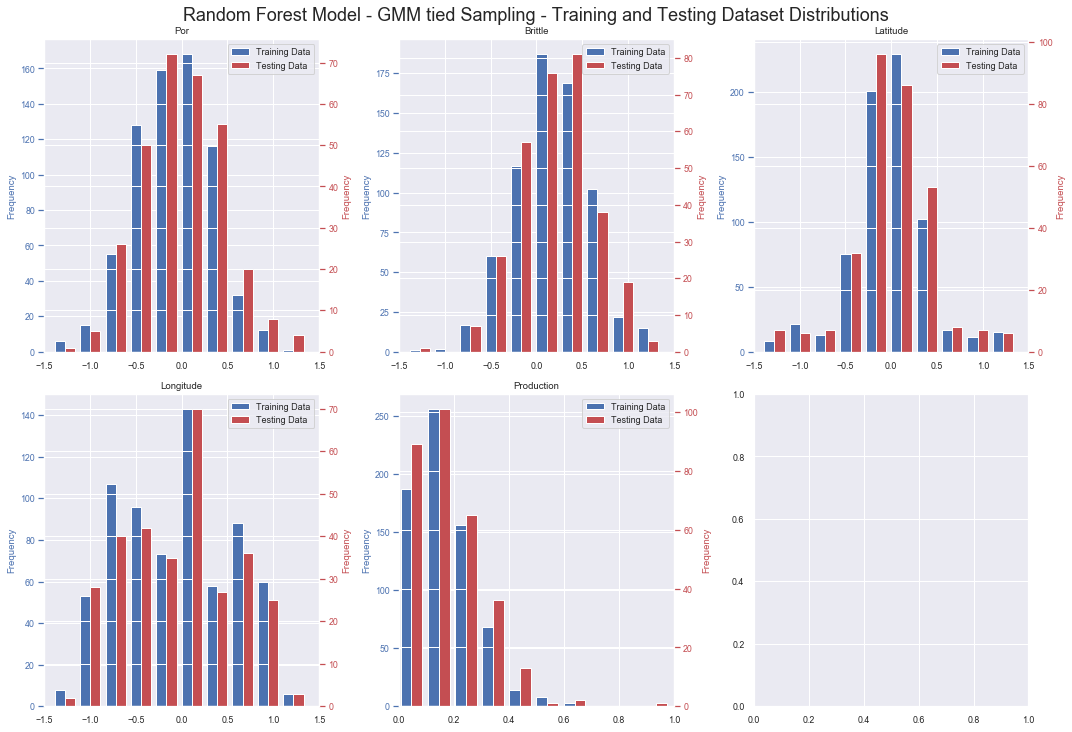

In [28]:
###################################################################################################################
if sampling_method == 'Random':
    X_train2, X_test2, y_train2, y_test2 = train_test_split(pred_norm, response_norm, test_size=0.3, random_state=random_seed_sampling_split)
    X_train20 = np.asarray(X_train2.to_numpy());    y_train20 = np.asarray(y_train2.to_numpy())
    X_test20 = np.asarray(X_test2.to_numpy());      y_test20 = np.asarray(y_test2.to_numpy())
    X_train_parameters_rf = np.hstack([X_train20, y_train20])
    X_test_parameters_rf = np.hstack([X_test20, y_test20])
    print(X_train_parameters_rf.shape)
    print(X_test_parameters_rf.shape)
    ###################################################################################################################
else:
    training_data_new0, testing_data_new0 = training_testing_datasets1(random_seed_sampling_split, False, 0.3, ArrayVals, sampling_method)    
    traindata_rf0 = np.asarray(training_data_new0[parameters_rf].to_numpy())
    testdata_rf0 = np.asarray(testing_data_new0[parameters_rf].to_numpy())
    X_train20 = traindata_rf0[:, :-1];    y_train20 = traindata_rf0[:, -1]
    X_test20 = testdata_rf0[:, :-1];      y_test20 = testdata_rf0[:, -1]
    print(traindata_rf0.shape)
    print(testdata_rf0.shape)
###################################################################################################################
def rf_histograms_sampling(np_x_train, np_x_test, np_y_train, np_y_test, min_plot, max_plot, print_str):
    """
    :param np_x_train: The predictive features training data
    :param np_x_test: The predictive features testing data
    :param np_y_train: The target feature training data
    :param np_y_test: The target feature testing data
    :param min_plot: The minimum x and y-axis values
    :param max_plot: The maximum x and y-axis values
    :param print_str: The text belonging to the sampling method used to complete the title of the plots
    :return: None
    """
    hist_data1 = [np_x_train[:, 0], np_x_test[:, 0]]
    hist_data2 = [np_x_train[:, 1], np_x_test[:, 1]]
    hist_data3 = [np_x_train[:, 2], np_x_test[:, 2]]
    hist_data4 = [np_x_train[:, 3], np_x_test[:, 3]]
    hist_data5 = [np_y_train, np_y_test]    
    colors = ['b', 'r']
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    ax01 = ax1.twinx()
    ax1.hist(hist_data1, color=colors)
    n, bins, patches = ax1.hist(hist_data1)
    ax1.cla()
    width = (bins[1] - bins[0]) * 0.4
    bins_shifted = bins + width
    train_hist1 = ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
    test_hist1 = ax01.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])
    ax1.set_ylabel("Frequency", color=colors[0])
    ax01.set_ylabel("Frequency", color=colors[1])
    ax1.tick_params('y', colors=colors[0])
    ax01.tick_params('y', colors=colors[1])
    plt.title('Por')
    plt.legend((train_hist1, test_hist1), ('Training Data', 'Testing Data'), loc='upper right', ncol=1, fontsize=9)
    plt.xlim(min_plot, max_plot)
    
    ax02 = ax2.twinx()
    ax2.hist(hist_data2, color=colors)
    n, bins, patches = ax2.hist(hist_data2)
    ax2.cla()
    width = (bins[1] - bins[0]) * 0.4
    bins_shifted = bins + width
    train_hist2 = ax2.bar(bins[:-1], n[0], width, align='edge', color=colors[0], label='Training Data')
    test_hist2 = ax02.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1], label='Testing Data')
    ax2.set_ylabel("Frequency", color=colors[0])
    ax02.set_ylabel("Frequency", color=colors[1])
    ax2.tick_params('y', colors=colors[0])
    ax02.tick_params('y', colors=colors[1])
    plt.title('Brittle')
    plt.legend((train_hist2, test_hist2), ('Training Data', 'Testing Data'), loc='upper right', ncol=1, fontsize=9)
    plt.xlim(min_plot, max_plot)
    
    ax03 = ax3.twinx()
    ax3.hist(hist_data3, color=colors)
    n, bins, patches = ax3.hist(hist_data3)
    ax3.cla()
    width = (bins[1] - bins[0]) * 0.4
    bins_shifted = bins + width
    train_hist3 = ax3.bar(bins[:-1], n[0], width, align='edge', color=colors[0], label='Training Data')
    test_hist3 = ax03.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1], label='Testing Data')
    ax3.set_ylabel("Frequency", color=colors[0])
    ax03.set_ylabel("Frequency", color=colors[1])
    ax3.tick_params('y', colors=colors[0])
    ax03.tick_params('y', colors=colors[1])
    plt.title('Latitude')
    plt.legend((train_hist3, test_hist3), ('Training Data', 'Testing Data'), loc='upper right', ncol=1, fontsize=9)
    plt.xlim(min_plot, max_plot)
    
    ax04 = ax4.twinx()
    ax4.hist(hist_data4, color=colors)
    n, bins, patches = ax4.hist(hist_data4)
    ax4.cla()
    width = (bins[1] - bins[0]) * 0.4
    bins_shifted = bins + width
    train_hist4 = ax4.bar(bins[:-1], n[0], width, align='edge', color=colors[0], label='Training Data')
    test_hist4 = ax04.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1], label='Testing Data')
    ax4.set_ylabel("Frequency", color=colors[0])
    ax04.set_ylabel("Frequency", color=colors[1])
    ax4.tick_params('y', colors=colors[0])
    ax04.tick_params('y', colors=colors[1])
    plt.title('Longitude')
    plt.legend((train_hist4, test_hist4), ('Training Data', 'Testing Data'), loc='upper right', ncol=1, fontsize=9)
    plt.xlim(min_plot, max_plot)
    
    ax05 = ax5.twinx()
    ax5.hist(hist_data5, color=colors)
    n, bins, patches = ax5.hist(hist_data5)
    ax5.cla()
    width = (bins[1] - bins[0]) * 0.4
    bins_shifted = bins + width
    
    train_hist5 = ax5.bar(bins[:-1], n[0], width, align='edge', color=colors[0], label='Training Data')
    test_hist5 = ax05.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1], label='Testing Data')
    
    ax5.set_ylabel("Frequency", color=colors[0])
    ax05.set_ylabel("Frequency", color=colors[1])
    ax5.tick_params('y', colors=colors[0])
    ax05.tick_params('y', colors=colors[1])
    plt.title('Production')
    plt.legend((train_hist5, test_hist5), ('Training Data', 'Testing Data'), loc='upper right', ncol=1, fontsize=9)
    plt.xlim(0.0, 1.0)

    fig = plt.gcf()
    fig.suptitle('Random Forest Model - ' + print_str + ' Sampling - Training and Testing Dataset Distributions', fontsize=18, y=1.0125)
    fig.tight_layout()
    fig.savefig(path_db + '/RF_Histograms.png', bbox_inches='tight')
    plt.show()

###################################################################################################################
rf_histograms_sampling(X_train20, X_test20, y_train20, y_test20, -1.5, 1.5, print_str)
###################################################################################################################

#### Plot the resulting training and testing datasets to see how well each dataset represents the map area
As mentioned before, we employ scatter plots using latitude and longitude to plot the data in the feature space in order to validate whether the resulting sampling method has data points coming from similar geological regions with similar production rate values in the resulting training and testing datasets. Of course, these results are with the optimal random state in order to sample from a given cluster, or the entire map area in the case of random sampling for generating the final derived training and testing dataset. 

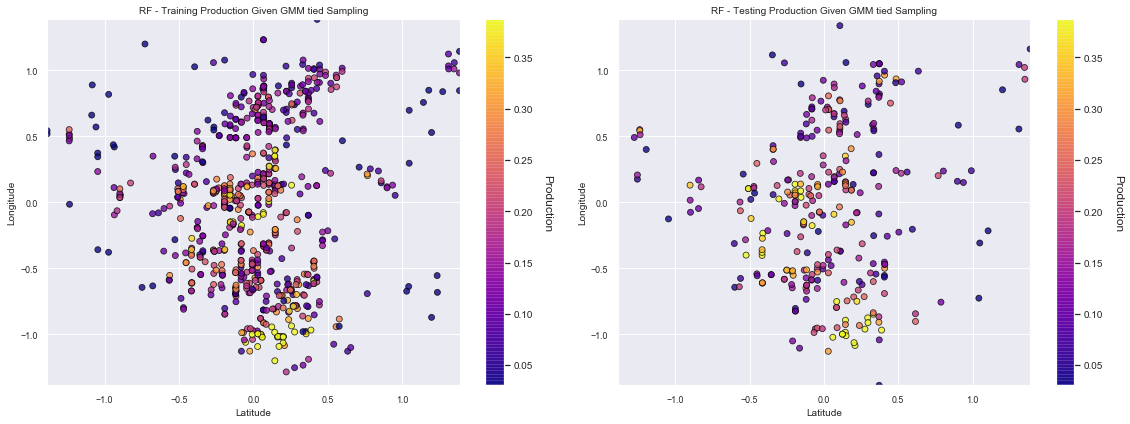

In [29]:
###################################################################################################################
lat = df['Latitude']; long = df['Longitude']; cum_oil_365 = df['Production']
lat_train = X_train20[:, 2]; long_train = X_train20[:, 3]; cum_oil_365_train = y_train20
lat_test = X_test20[:, 2];   long_test = X_test20[:, 3];   cum_oil_365_test = y_test20
cum_oil_365_p05 = np.percentile(cum_oil_365.values, 5, axis=0)
cum_oil_365_p95 = np.percentile(cum_oil_365.values, 95, axis=0)
###################################################################################################################
fig = plt.figure(figsize=(16, 6))
###################################################################################################################
ax1 = fig.add_subplot(1, 2, 1); ax = ax1
cax = ax.scatter(lat_train, long_train, c=cum_oil_365_train.ravel(), cmap=plt.cm.plasma, vmin=cum_oil_365_p05, vmax=cum_oil_365_p95, alpha=0.8, linewidths=0.8, edgecolors="black")
cbar = fig.colorbar(cax)
cbar.set_label('Production', rotation=270, size=12, labelpad=20)
cbar.ax.tick_params(labelsize=10)
ax.set_ylabel('Longitude', size=10)
ax.set_xlabel('Latitude', size=10)
ax.set_title('RF - Training Production Given ' + str(print_str) + ' Sampling', size=10)
ax.set_ylim([long.min(), long.max()])
ax.set_xlim([lat.min(), lat.max()])
###################################################################################################################
ax2 = fig.add_subplot(1, 2, 2); ax = ax2
cax = ax.scatter(lat_test, long_test, c=cum_oil_365_test.ravel(), cmap=plt.cm.plasma, vmin=cum_oil_365_p05, vmax=cum_oil_365_p95, alpha=0.8, linewidths=0.8, edgecolors="black")
cbar = fig.colorbar(cax)
cbar.set_label('Production', rotation=270, size=12, labelpad=20)
cbar.ax.tick_params(labelsize=10)
ax.set_ylabel('Longitude', size=10)
ax.set_xlabel('Latitude', size=10)
ax.set_title('RF - Testing Production Given ' + str(print_str) + ' Sampling', size=10)
ax.set_ylim([long.min(), long.max()])
ax.set_xlim([lat.min(), lat.max()])
###################################################################################################################
fig.tight_layout()
fig.savefig(path_db + '/RF_Production_ScatterPlot.png', bbox_inches='tight')
plt.show()
###################################################################################################################

#### Conclusion/Summary of Production Prediction Workflow:
* By performing feature engineering, the machine learning methods were able to perform optimally, thereby enabling more reliable results with potential outliers removed and the variances of each feature standardized to one with a mean of zero.
* During feature selection, I utilized the derived correlation coefficients plus the mutual information and feature importance to find the 4 optimal predictive features that had a high correlation to Production, yet were not highly correlated between each other. Computing these coefficients was another way to mitigate the chance of multicollinearity (i.e., decrease the dimensionality of the problem, and decrease the chance of redundant features), and to allow for the random forest model to perform optimally.
* Random Sampling, K-means Clustering and GMMs were employed to generate various training and testing datasets. The clustering methods aimed to achieve a reduction in the sampling bias by exposing the predictive machine learning models to data points representing similar geological regions and feature value distributions in both the derived training and testing datasets. I performed a 70/30 train-test split, and found that the clustering methods employed derived clusters based on geological regions that had similar production rate values. This proecdure did seem to reduce the sampling bias in most of the given training and testing dataset scenarios when analyzing histogram distributions of the features and scatter plots of the production wells.
* The 4 optimal predictive features found for the random forest method were consistent for each training and testing dataset generated, and allowed for extremely high accuracy and extremely low error in the machine learning model performance. Of course, finding the optimal random state to sample from the clusters or entire map helped in achieving these results.
* In the end, this workflow has created an enhanced AI workflow for finding a relationship between a set of predictive features and oil production in order to optimize hydrocarbon production when hydraulically fracturing the reservoir.